# CRAWL DATA

In [1]:
# =============================================================================
# DS108 RAINFALL PREDICTION PIPELINE - SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import refactored modules
from src.data.crawler import NASAPowerCrawler
from src.data.loader import DataLoader  
from src.data.dataquality import assess_data_quality
from src.config.constants import Config

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("🌟 DS108 RAINFALL PREDICTION PIPELINE")
print("🎯 Goal: Predict rainfall for Ho Chi Minh City")
print("📅 Period: 25+ years of NASA POWER data")

🌟 DS108 RAINFALL PREDICTION PIPELINE
🎯 Goal: Predict rainfall for Ho Chi Minh City
📅 Period: 25+ years of NASA POWER data


In [2]:
# =============================================================================
# SECTION 1: DATA COLLECTION & LOADING
# =============================================================================

print("📊 SECTION 1: DATA COLLECTION & LOADING")

# Option 1: Load existing data 
loader = DataLoader()
df_raw = loader.load_data(rename_columns=False)

# Option 2: Crawl fresh data (uncomment if needed)
# crawler = NASAPowerCrawler()
# df_raw = crawler.crawl_data()

print(f"Raw data shape: {df_raw.shape if df_raw is not None else 'None'}")

📊 SECTION 1: DATA COLLECTION & LOADING
📂 LOADING WEATHER DATA
✅ Data loaded: (9252, 23)
📅 Date column converted
Raw data shape: (9252, 23)


In [3]:
# Apply Vietnamese column mapping and basic preprocessing
if df_raw is not None:
    df = df_raw.rename(columns=Config.COLUMN_MAPPING)
    
    # Convert date column
    date_col = 'Ngày'
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
    
    print(f"Processed data shape: {df.shape}")
    print(f"Date range: {df[date_col].min()} → {df[date_col].max()}")
    print(f"Weather parameters: {len([col for col in df.columns if col not in ['Ngày', 'Vĩ độ', 'Kinh độ']])}")
else:
    print("❌ Data loading failed")

Processed data shape: (9252, 23)
Date range: 2000-01-01 00:00:00 → 2025-04-30 00:00:00
Weather parameters: 20


# Thông tin bộ dữ liệu

**Dữ liệu NASA POWER API cho Thành phố Hồ Chí Minh**

**a) Chức năng (nội dung) của bộ dữ liệu là gì?**

Bộ dữ liệu này chứa thông tin khí tượng và bề mặt đất hàng ngày cho Thành phố Hồ Chí Minh, được thu thập tự động thông qua API NASA Prediction Of Worldwide Energy Resources (POWER). Dữ liệu bao gồm nhiều tham số quan trọng như:

*   **Nhiệt độ**: trung bình, tối thiểu, tối đa, điểm sương, bầu ướt, nhiệt độ bề mặt đất
*   **Độ ẩm**: tương đối, tuyệt đối  
*   **Lượng mưa**: mục tiêu dự đoán chính
*   **Áp suất bề mặt**
*   **Gió**: tốc độ trung bình, tối đa, hướng gió ở các độ cao khác nhau
*   **Bức xạ mặt trời**: bức xạ sóng dài xuống bề mặt
*   **Độ ẩm đất**: bề mặt, vùng rễ, toàn bộ mặt cắt

Dữ liệu được cung cấp cho mỗi ngày trong khoảng thời gian được chỉ định từ 01/01/2000 đến 30/04/2025, phục vụ mục tiêu dự đoán thời tiết cho toàn thành phố.

**b) Nguồn gốc của bộ dữ liệu?**

Dữ liệu gốc được cung cấp bởi dự án NASA POWER. Dữ liệu cụ thể trong bộ dữ liệu này được thu thập bằng cách gọi đến API công khai của NASA POWER:

*   **Nguồn dữ liệu:** NASA POWER (Prediction Of Worldwide Energy Resources)
*   **API Endpoint:** `https://power.larc.nasa.gov/api/temporal/daily/point`
*   **Phương pháp:** Single request crawl với 20 parameters (trong giới hạn API)
*   **Vị trí:** Tọa độ trung tâm TP.HCM (lat: 10.78, lon: 106.7)

**c) Cấu trúc các tập tin của bộ dữ liệu? Ý nghĩa từng tập tin.**

Dữ liệu sau khi thu thập được lưu trữ trong thư mục `nasa_power_hcmc_data` với cấu trúc đơn giản:

1.  **Tệp dữ liệu chính:**
    *   **Tên tệp:** `hcmc_weather_data_{Ngày_Bắt_Đầu}_{Ngày_Kết_Thúc}.csv`
    *   **Nội dung:** Chứa dữ liệu hàng ngày của tất cả 20 tham số khí tượng cho TP.HCM trong khoảng thời gian xác định. Mỗi hàng đại diện cho một ngày.

**d) Các thông tin nào mà các record (bản ghi) lưu trữ?**

Mỗi record (hàng trong tệp CSV) tương ứng với dữ liệu của một ngày cho TP.HCM và chứa các cột sau:

**Thông tin địa lý và thời gian:**
*   **DATE:** Ngày ghi nhận dữ liệu (định dạng datetime)
*   **LATITUDE:** Vĩ độ điểm đại diện TP.HCM (10.78)
*   **LONGITUDE:** Kinh độ điểm đại diện TP.HCM (106.7)

**Nhóm 1 - Nhiệt độ, độ ẩm, mưa, áp suất (11 chỉ số):**
*   **PRECTOTCORR:** Lượng mưa đã hiệu chỉnh (mm/ngày) - *Biến mục tiêu*
*   **QV2M:** Độ ẩm tuyệt đối ở 2m (g/kg)
*   **RH2M:** Độ ẩm tương đối ở 2m (%)
*   **T2M:** Nhiệt độ trung bình ở 2m (°C)
*   **T2MDEW:** Điểm sương/sương giá ở 2m (°C)
*   **T2MWET:** Nhiệt độ bầu ướt ở 2m (°C)
*   **T2M_MAX:** Nhiệt độ tối đa ở 2m (°C)
*   **TS:** Nhiệt độ bề mặt đất (°C)
*   **T2M_MIN:** Nhiệt độ tối thiểu ở 2m (°C)
*   **ALLSKY_SFC_LW_DWN:** Bức xạ sóng dài xuống bề mặt (MJ/m²/ngày)
*   **PS:** Áp suất bề mặt (kPa)

**Nhóm 2 - Gió và độ ẩm đất (9 chỉ số):**
*   **WS10M:** Tốc độ gió ở 10m (m/s)
*   **WD10M:** Hướng gió ở 10m (Độ)
*   **WS10M_MAX:** Tốc độ gió tối đa ở 10m (m/s)
*   **WS2M_MAX:** Tốc độ gió tối đa ở 2m (m/s)
*   **WS2M:** Tốc độ gió ở 2m (m/s)
*   **WD2M:** Hướng gió ở 2m (Độ)
*   **GWETPROF:** Độ ẩm đất theo mặt cắt (tỷ lệ 0-1)
*   **GWETTOP:** Độ ẩm bề mặt đất (tỷ lệ 0-1)
*   **GWETROOT:** Độ ẩm vùng rễ (tỷ lệ 0-1)

**Ghi chú quan trọng:**
- Giá trị `-999` biểu thị dữ liệu thiếu hoặc không thể tính toán
- Dữ liệu được crawl trong 1 lần duy nhất với 20 parameters (tuân thủ giới hạn API)
- Tổng cộng có 20 weather parameters + 3 metadata columns cho việc dự đoán thời tiết TP.HCM

### Tham khảo

*   **NASA POWER Data Access Viewer:** [https://power.larc.nasa.gov/data-access-viewer/](https://power.larc.nasa.gov/data-access-viewer/)
*   **NASA POWER Documentation:** [https://power.larc.nasa.gov/docs/](https://power.larc.nasa.gov/docs/)
*   **NASA POWER API Documentation:** [https://power.larc.nasa.gov/docs/services/api/](https://power.larc.nasa.gov/docs/services/api/)

# Data Quality Assessment

In [4]:
# =============================================================================
# SECTION 2: DATA QUALITY ASSESSMENT
# =============================================================================

print("🔍 SECTION 2: DATA QUALITY ASSESSMENT")

# Run comprehensive quality assessment
quality_results = assess_data_quality(df, target_col='Lượng mưa')

# Display results
print(f"\nQuality Assessment Results:")
for section, results in quality_results.items():
    print(f"{section}: {results}")

🔍 SECTION 2: DATA QUALITY ASSESSMENT
🔍 DATA QUALITY ASSESSMENT
📊 Dataset: (9252, 23)
❓ Missing data: 0.00%
🔄 Duplicates: 0 rows (0.00%)
🏆 Quality Score: 100/100

Quality Assessment Results:
basic_info: {'shape': (9252, 23), 'memory_mb': 1.6236305236816406, 'columns': ['Lượng mưa', 'Độ ẩm tuyệt đối 2m', 'Độ ẩm tương đối 2m', 'Nhiệt độ 2m', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Nhiệt độ tối đa 2m', 'Nhiệt độ bề mặt đất', 'Nhiệt độ tối thiểu 2m', 'Bức xạ sóng dài xuống', 'Áp suất bề mặt', 'Tốc độ gió 10m', 'Hướng gió 10m', 'Tốc độ gió tối đa 10m', 'Tốc độ gió tối đa 2m', 'Tốc độ gió 2m', 'Hướng gió 2m', 'Độ ẩm đất mặt cắt', 'Độ ẩm đất bề mặt', 'Độ ẩm đất vùng rễ', 'Ngày', 'Vĩ độ', 'Kinh độ']}
missing_data: {'total_missing': 0, 'missing_percentage': 0.0, 'columns_with_missing': {}}
duplicates: {'duplicate_rows': 0, 'duplicate_percentage': 0.0}
data_types: {'float64': 22, 'datetime64[ns]': 1}
target_variable: {'exists': True, 'missing_count': 0, 'missing_percentage': 0.0, 'min_value': 0.

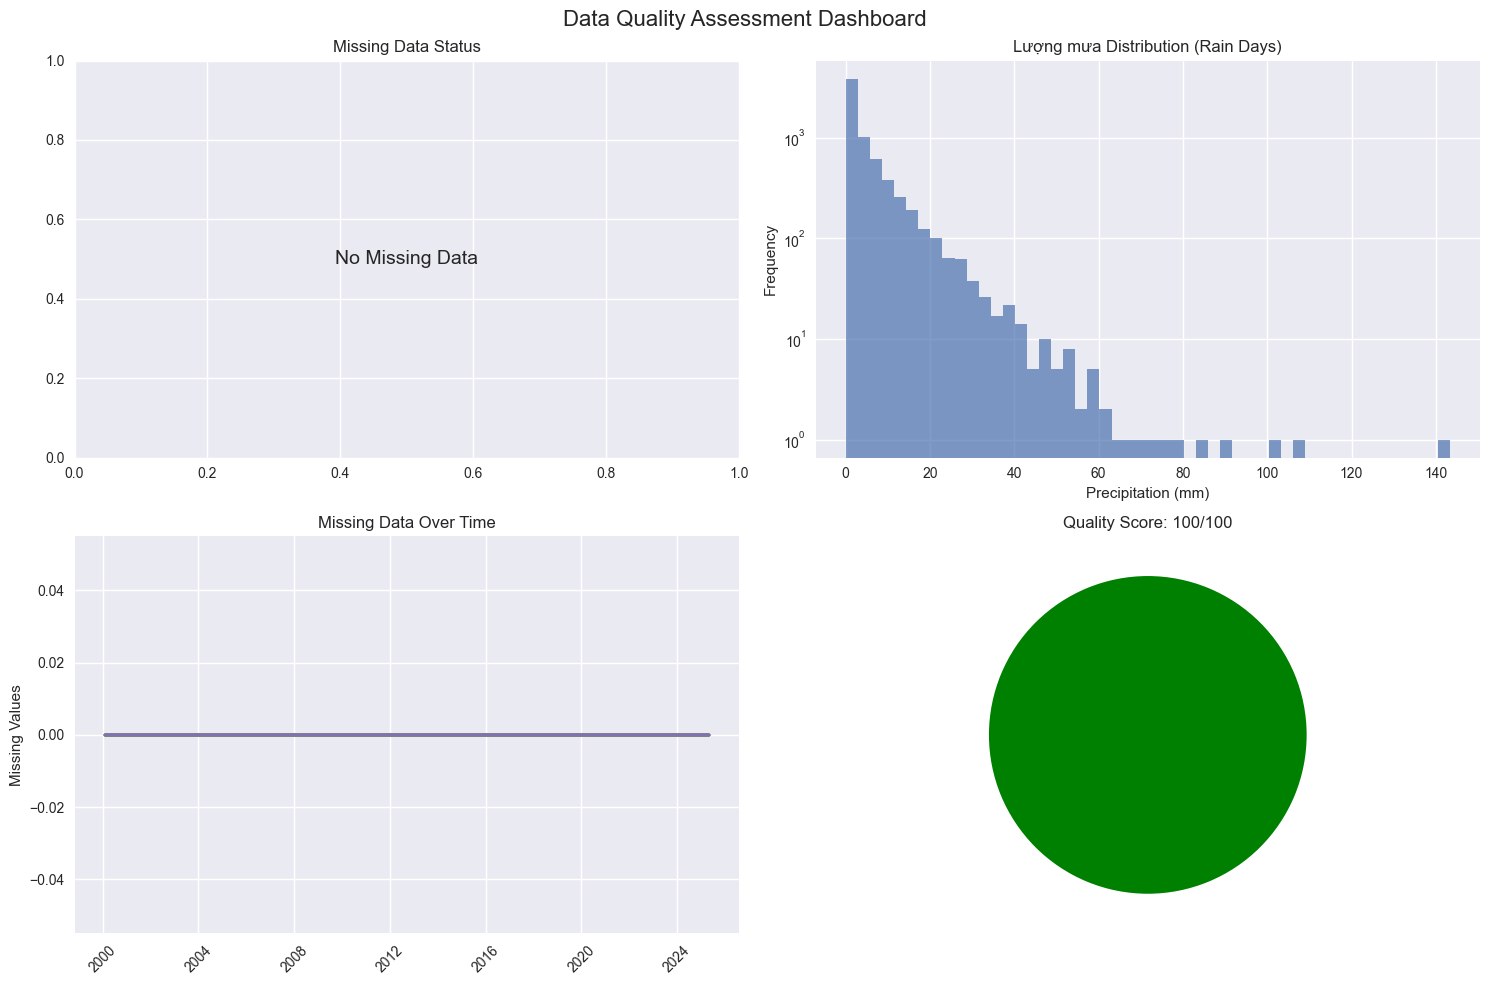

In [5]:
# Create quality assessment dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Assessment Dashboard', fontsize=16)

# Missing data
missing_data = quality_results['missing_data']
if missing_data['columns_with_missing']:
    missing_df = pd.DataFrame(list(missing_data['columns_with_missing'].items()), 
                             columns=['Column', 'Missing_Count'])
    missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / len(df)) * 100
    
    axes[0,0].bar(range(len(missing_df)), missing_df['Missing_Percentage'])
    axes[0,0].set_title('Missing Data by Column')
    axes[0,0].set_ylabel('Missing %')
    axes[0,0].set_xticks(range(len(missing_df)))
    axes[0,0].set_xticklabels(missing_df['Column'], rotation=45, ha='right')
else:
    axes[0,0].text(0.5, 0.5, 'No Missing Data', ha='center', va='center', 
                   transform=axes[0,0].transAxes, fontsize=14)
    axes[0,0].set_title('Missing Data Status')

# Target variable distribution
target_col = 'Lượng mưa'
if target_col in df.columns:
    target_data = df[target_col].dropna()
    axes[0,1].hist(target_data[target_data > 0], bins=50, alpha=0.7)
    axes[0,1].set_title(f'{target_col} Distribution (Rain Days)')
    axes[0,1].set_xlabel('Precipitation (mm)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_yscale('log')

# Data completeness over time
df_monthly = df.set_index('Ngày').resample('M').apply(lambda x: x.isnull().sum().sum())
axes[1,0].plot(df_monthly.index, df_monthly.values)
axes[1,0].set_title('Missing Data Over Time')
axes[1,0].set_ylabel('Missing Values')
axes[1,0].tick_params(axis='x', rotation=45)

# Quality score
overall_score = quality_results['overall_score']
axes[1,1].pie([overall_score, 100-overall_score], 
              colors=['green' if overall_score >= 80 else 'orange' if overall_score >= 70 else 'red', 'lightgray'],
              startangle=90)
axes[1,1].set_title(f'Quality Score: {overall_score}/100')

plt.tight_layout()
plt.show()

# Time Series Analysis

## Distribution Analysis

📊 SECTION 3: DISTRIBUTION ANALYSIS
🚀 STARTING COMPREHENSIVE DISTRIBUTION ANALYSIS
📊 DISTRIBUTION ANALYSIS INITIALIZED
   - Total Features: 22
   - Analysis Features: 20
   - Target Variable: Lượng mưa
   - Sample Size: 9,252

📋 5. DISTRIBUTION ANALYSIS SUMMARY REPORT

📈 1. DESCRIPTIVE STATISTICS SUMMARY
📊 Comprehensive Descriptive Statistics:

🔢 Basic Statistics:
              Feature  Count     Mean  Median   Mode     Std   Min    Max
            Lượng mưa   9252   3.9293    0.65   0.00  7.6473  0.00 143.31
   Độ ẩm tuyệt đối 2m   9252  17.2692   18.15  19.11  2.3491  8.14  21.47
   Độ ẩm tương đối 2m   9252  77.6260   82.49  88.46 12.4275 40.84  95.49
          Nhiệt độ 2m   9252  27.4593   27.01  26.91  1.9548 19.89  34.30
        Điểm sương 2m   9252  22.5162   23.50  24.35  2.4122 10.82  26.26
  Nhiệt độ bầu ướt 2m   9252  24.9877   25.30  25.27  1.4066 17.23  28.29
   Nhiệt độ tối đa 2m   9252  32.4488   31.23  30.24  3.5078 23.01  42.93
  Nhiệt độ bề mặt đất   9252  28.0657   27

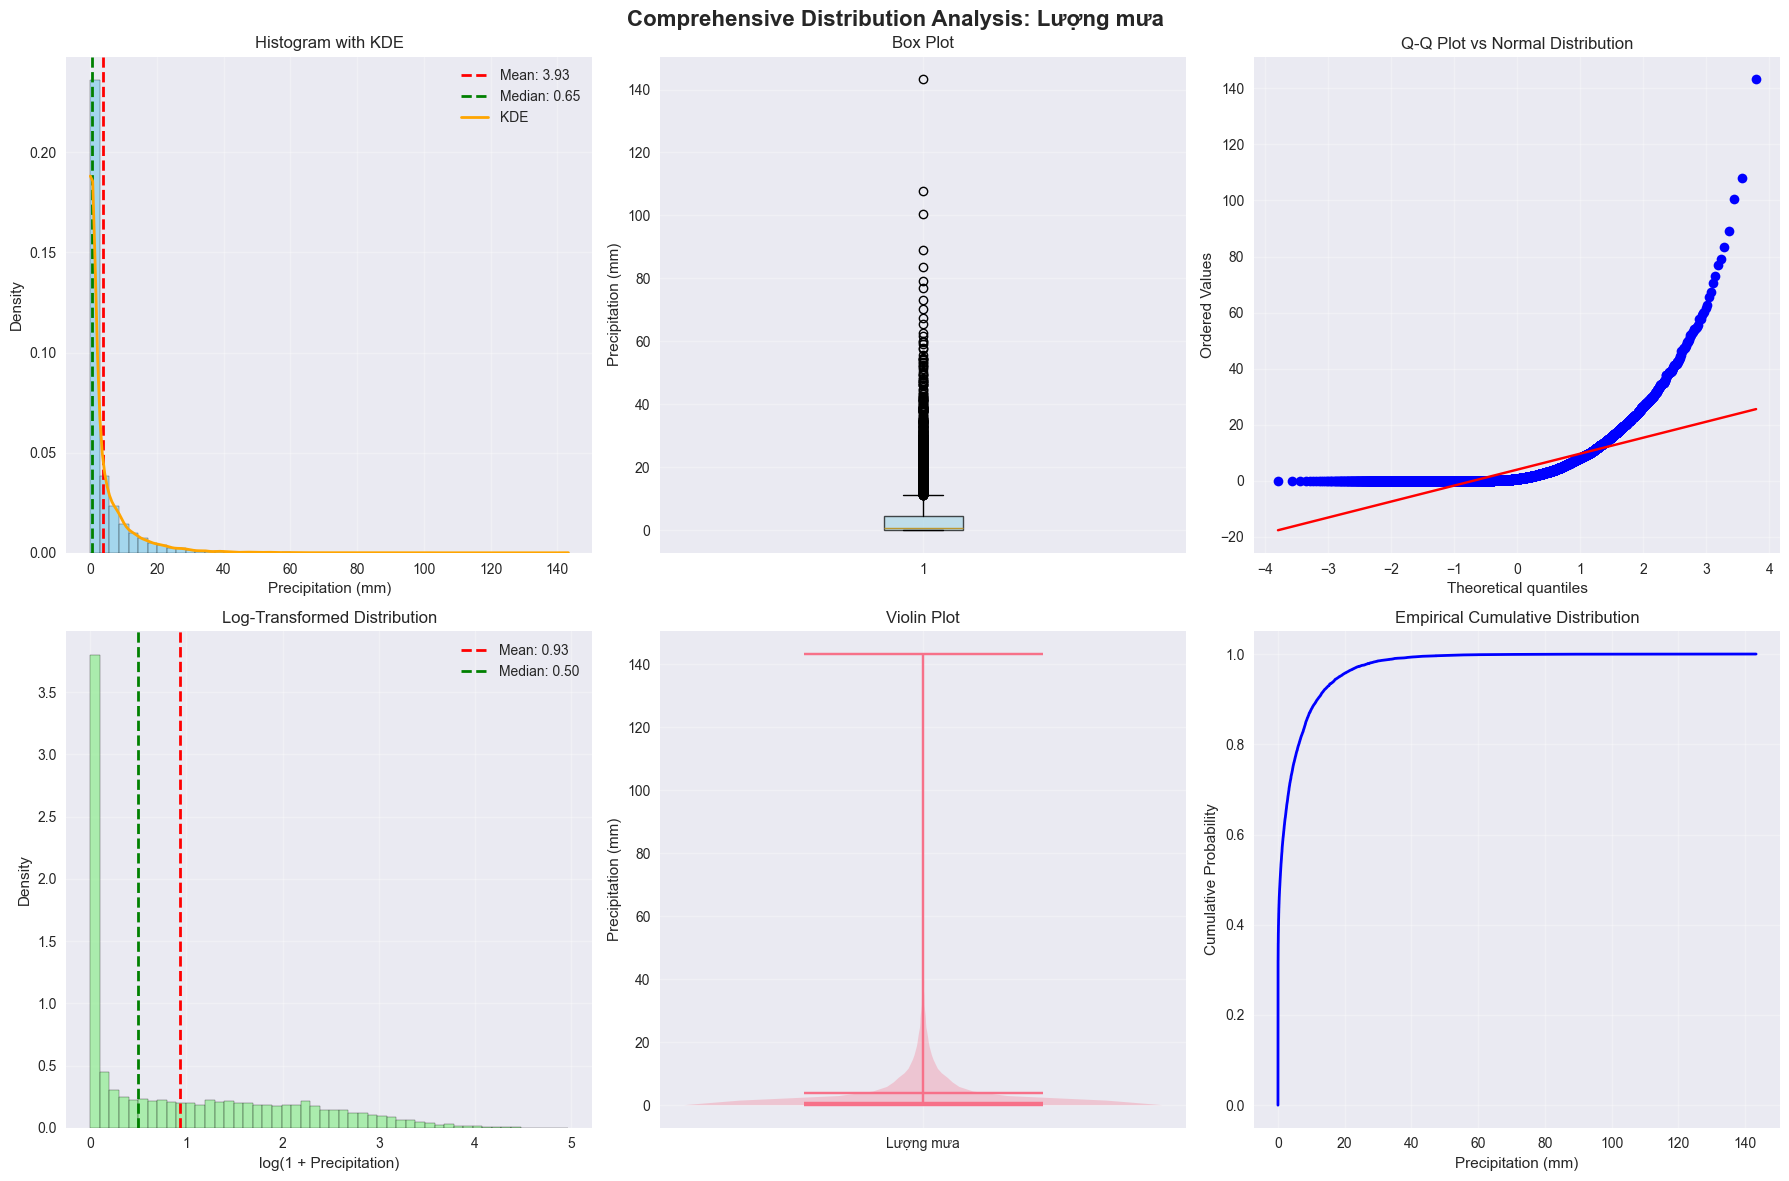


📊 Creating distribution overview for all features...


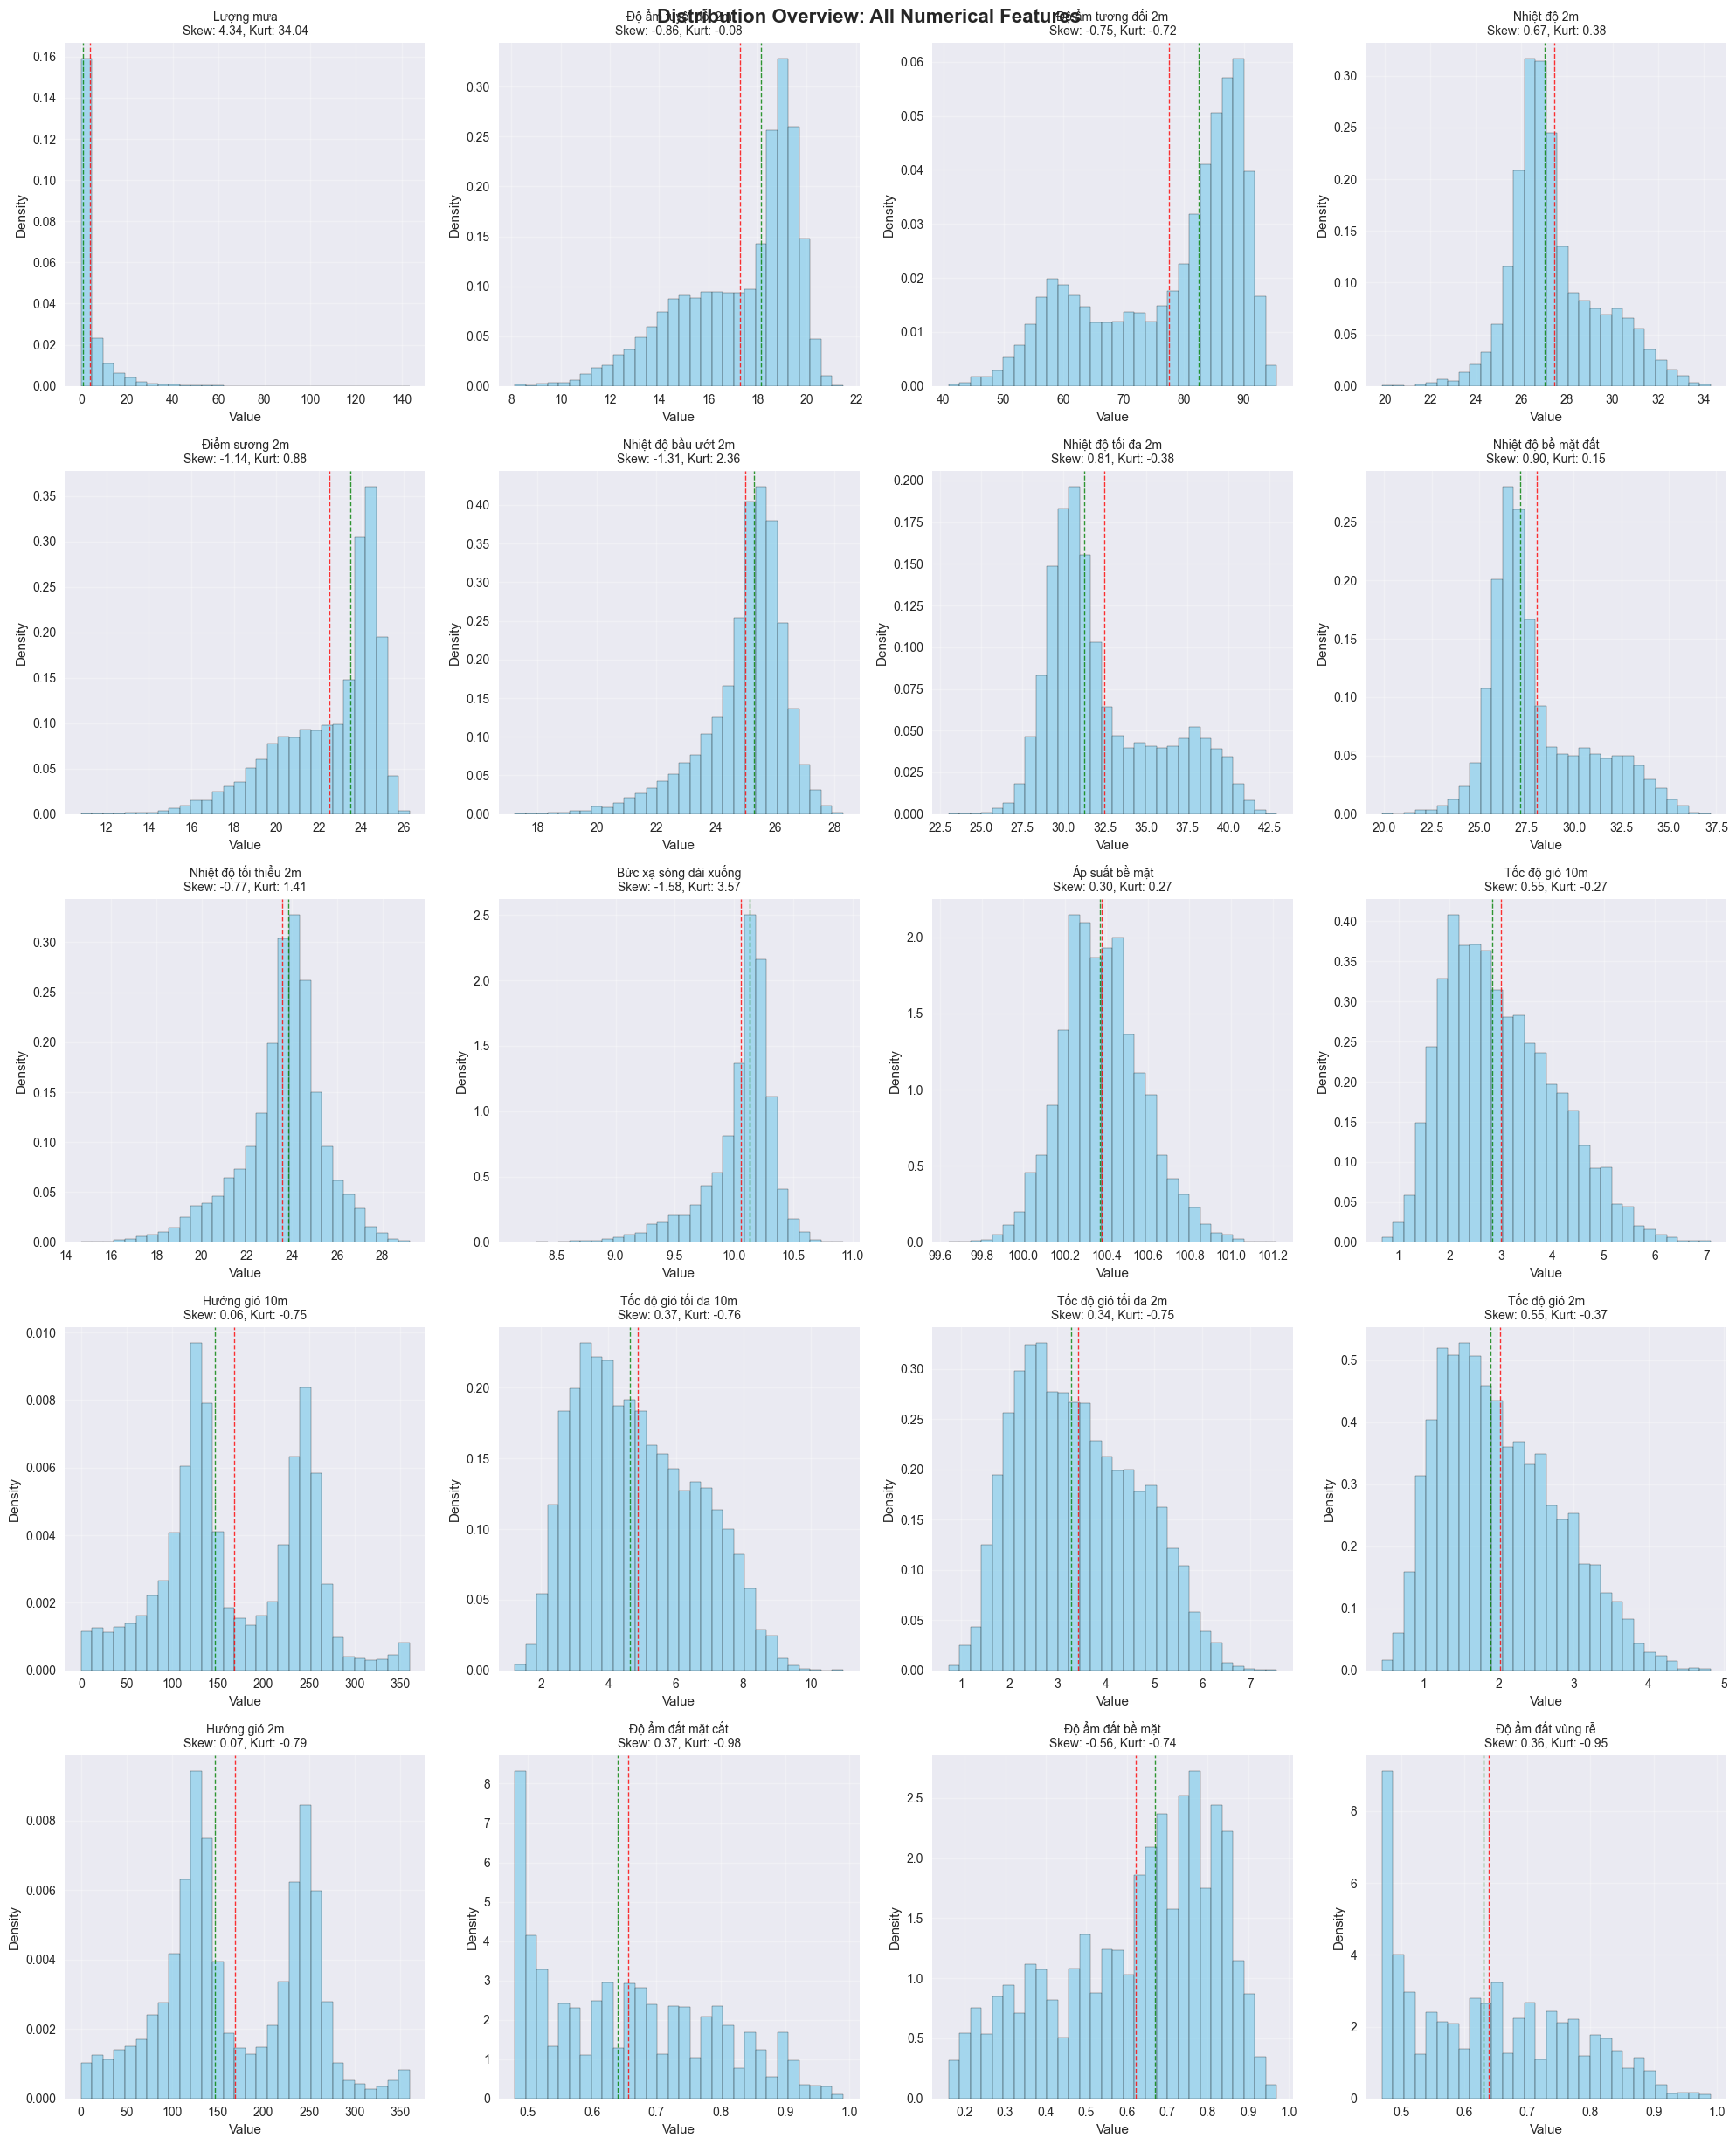


📐 Creating skewness and kurtosis comparison...


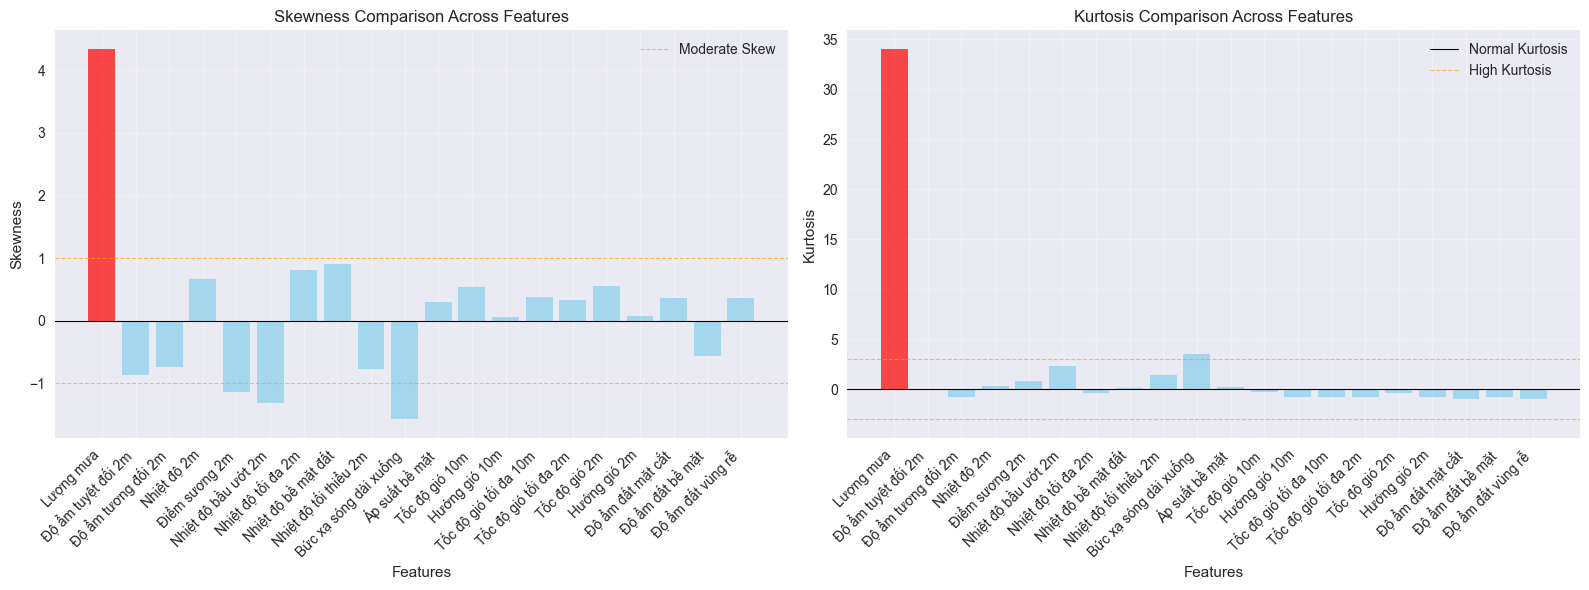


✅ DISTRIBUTION ANALYSIS COMPLETED

📋 DISTRIBUTION ANALYSIS SUMMARY:
   - target_skewness: 4.336759396909124
   - zero_rain_percentage: 25.73497622135754
   - normal_features_count: 0
   - high_skew_features: ['Lượng mưa', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Bức xạ sóng dài xuống']


In [6]:
# =============================================================================
# SECTION 3: DISTRIBUTION ANALYSIS (USING REFACTORED MODULE)
# =============================================================================

print("📊 SECTION 3: DISTRIBUTION ANALYSIS")

# Import refactored Distribution Analysis module
from src.analysis.DistributionAnalysis import analyze_distributions

# Run comprehensive distribution analysis with visualization
distribution_results = analyze_distributions(
    df=df, 
    target_col='Lượng mưa',
    include_visualization=True
)

# Display summary insights
print("\n📋 DISTRIBUTION ANALYSIS SUMMARY:")
for key, value in distribution_results['summary_insights'].items():
    print(f"   - {key}: {value}")

## Extreme Event Explore

⛈️ SECTION 4: EXTREME EVENT ANALYSIS

⛈️ COMPONENT 2: EXTREME EVENTS ANALYSIS
🔍 2.1 Extreme Events Definition
--------------------------------------------------
   📊 Extreme Event Thresholds:
      - 95th percentile: 18.45mm
      - 99th percentile: 34.86mm
      - 99.9th percentile: 67.01mm

   📈 Extreme Event Counts:
      - > 95th percentile: 463 events (5.00%)
      - > 99th percentile: 93 events (1.01%)
      - > 99.9th percentile: 10 events (0.11%)

🌪️ 2.2 Seasonal Patterns of Extreme Events
--------------------------------------------------


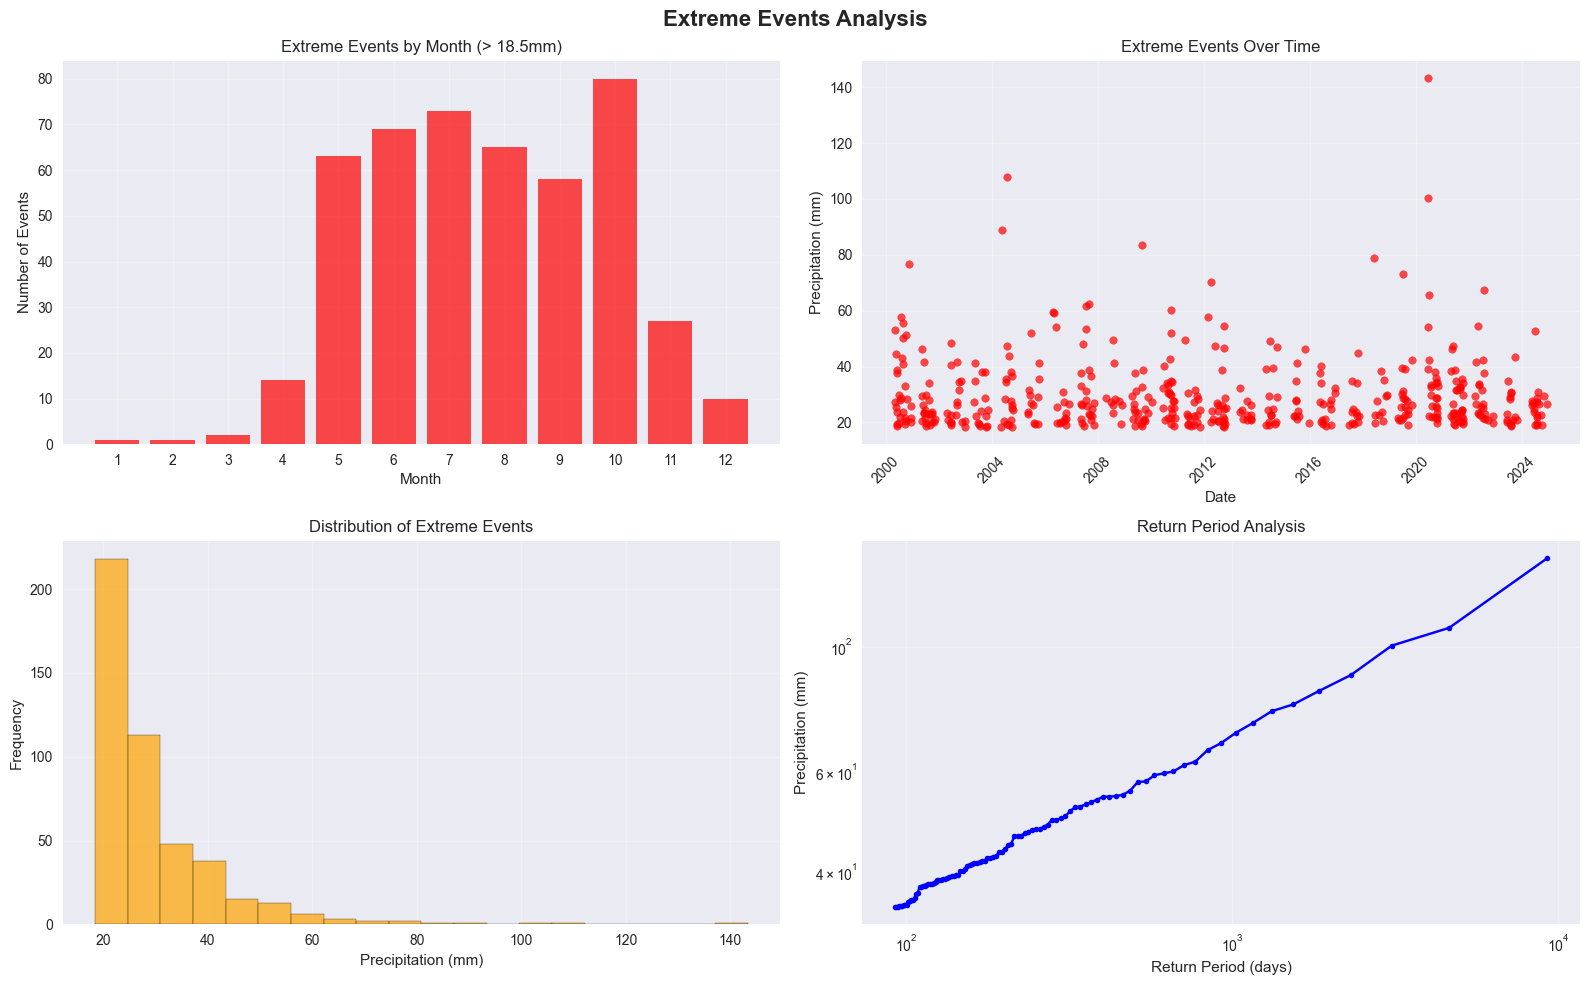

   📅 Peak extreme events month: 10

✅ EXTREME EVENTS ANALYSIS COMPLETED

📋 EXTREME EVENT ANALYSIS SUMMARY:
📊 Extreme Event Thresholds:
   - 95th percentile: 18.45mm
   - 99th percentile: 34.86mm
   - 99.9th percentile: 67.01mm

📈 Extreme Event Counts:
   - > 95th percentile: 463 events (5.00%)
   - > 99th percentile: 93 events (1.01%)
   - > 99.9th percentile: 10 events (0.11%)

📅 Seasonal Insights:
   - Peak extreme events month: Oct
   - Total extreme events analyzed: 463


In [7]:
# =============================================================================
# SECTION 4: EXTREME EVENT ANALYSIS (USING REFACTORED MODULE)
# =============================================================================

print("⛈️ SECTION 4: EXTREME EVENT ANALYSIS")

# Import refactored Extreme Event Analysis module  
from src.analysis.ExtremeEventAnalysis import analyze_extreme_events

# Run comprehensive extreme events analysis
extreme_results = analyze_extreme_events(
    df=df,
    target_col='Lượng mưa', 
    date_col='Ngày'
)

# Display summary results
if extreme_results['success']:
    print("\n📋 EXTREME EVENT ANALYSIS SUMMARY:")
    
    # Display thresholds
    thresholds = extreme_results['extreme_definition']['thresholds']
    print(f"📊 Extreme Event Thresholds:")
    print(f"   - 95th percentile: {thresholds['p95']:.2f}mm")
    print(f"   - 99th percentile: {thresholds['p99']:.2f}mm") 
    print(f"   - 99.9th percentile: {thresholds['p99_9']:.2f}mm")
    
    # Display counts
    counts = extreme_results['extreme_definition']['extreme_counts']
    total = extreme_results['extreme_definition']['total_records']
    print(f"\n📈 Extreme Event Counts:")
    print(f"   - > 95th percentile: {counts['p95']} events ({counts['p95']/total*100:.2f}%)")
    print(f"   - > 99th percentile: {counts['p99']} events ({counts['p99']/total*100:.2f}%)")
    print(f"   - > 99.9th percentile: {counts['p99_9']} events ({counts['p99_9']/total*100:.2f}%)")
    
    # Display seasonal patterns
    if extreme_results['seasonal_patterns']['success']:
        peak_month = extreme_results['seasonal_patterns']['peak_month']
        if peak_month:
            month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
            print(f"\n📅 Seasonal Insights:")
            print(f"   - Peak extreme events month: {month_names.get(peak_month, peak_month)}")
            print(f"   - Total extreme events analyzed: {extreme_results['seasonal_patterns']['total_extreme_events']}")
else:
    print(f"❌ Extreme Event Analysis failed: {extreme_results.get('error', 'Unknown error')}")

## Temporal Structure & Seasonality

### ANALYZER INITIALIZATION

In [8]:
from src.analysis.TemporalAnalysis import TemporalStructureAnalyzer
from src.config.constants import Config

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("🕐 TEMPORAL STRUCTURE ANALYSIS")
print("=" * 50)

# Initialize Temporal Analyzer
temporal_analyzer = TemporalStructureAnalyzer(
    df=df,  # Assuming df is your preprocessed dataframe
    target_col='Lượng mưa',
    date_col='Ngày'
)

print(f"✅ Temporal Analyzer initialized")
print(f"   📊 Data shape: {temporal_analyzer.df.shape}")
print(f"   📅 Date range: {temporal_analyzer.df[temporal_analyzer.date_col].min()} → {temporal_analyzer.df[temporal_analyzer.date_col].max()}")
print(f"   🎯 Target column: {temporal_analyzer.target_col}")

🕐 TEMPORAL STRUCTURE ANALYSIS
✅ Temporal Analyzer initialized
   📊 Data shape: (9252, 26)
   📅 Date range: 2000-01-01 00:00:00 → 2025-04-30 00:00:00
   🎯 Target column: Lượng mưa


### SEASONAL PATTERNS ANALYSIS

### 

🔍 Analyzing Seasonal Patterns
   - Time units: ['Month', 'DayOfYear', 'Year']
   - Aggregations: ['mean', 'std', 'median', 'count']
   - Quantile threshold: 0.5
   ✅ Seasonal analysis completed


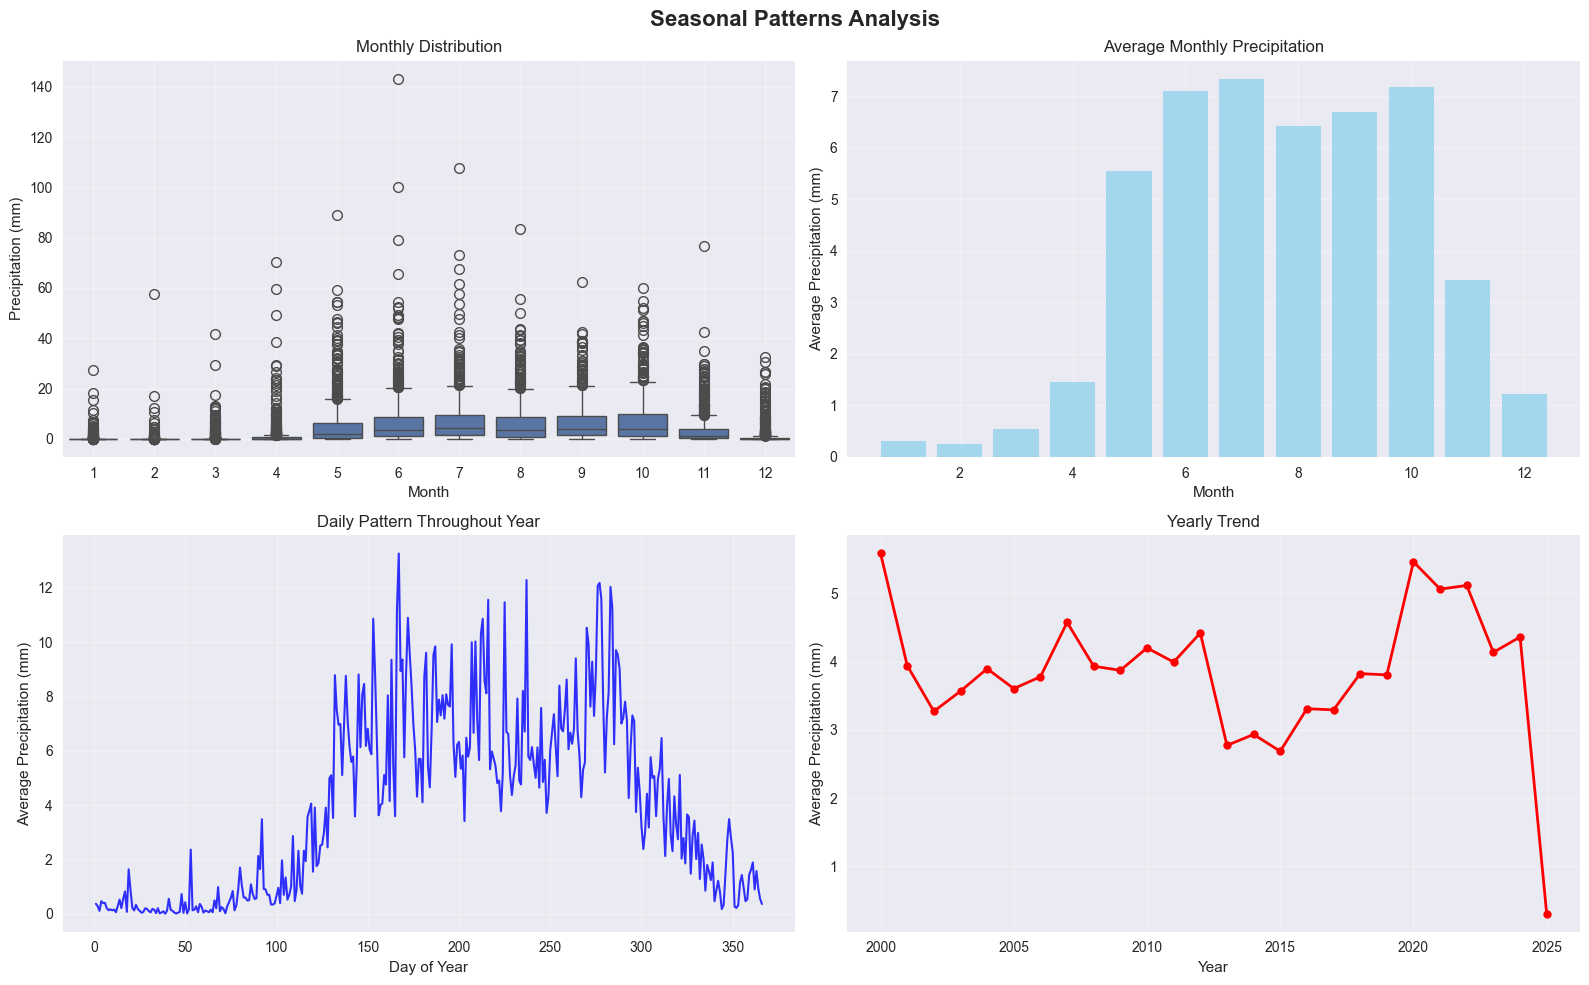

🌧️ Wet Season (>50th percentile): [5, 6, 7, 8, 9, 10]
☀️ Dry Season (<50th percentile): [1, 2, 3, 4, 11, 12]


In [9]:
# =============================================================================
# TEMPORAL ANALYSIS 1: SEASONAL PATTERNS
# =============================================================================

# Analysis with parameter tuning
seasonal_results = temporal_analyzer.analyze_seasonal_patterns(
    time_units=['Month', 'DayOfYear', 'Year'],  # Các đơn vị thời gian phân tích
    agg_functions=['mean', 'std', 'median', 'count'],  # Thống kê tính toán
    quantile_threshold=0.5  # Ngưỡng phân biệt mùa mưa/khô (50th percentile)
)

# Visualization
temporal_analyzer.plot_seasonal_patterns(
    seasonal_results=seasonal_results,
    figsize=(16, 10),
    color_scheme='default',
    show_grid=True
)

### FFT FREQUENCY ANALYSIS

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 365
   - Top periods to find: 50
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 39 total dominant periods
   📊 Returning top 20 dominant periods:
      1. 494 days
      2. 423 days
      3. 404 days
      4. 386 days
      5. 370 days
      6. 356 days
      7. 342 days
      8. 329 days
      9. 278 days
      10. 261 days
      11. 185 days
      12. 178 days
      13. 122 days
      14. 97 days
      15. 75 days
      16. 73 days
      17. 72 days
      18. 63 days
      19. 60 days
      20. 45 days
   📊 Displaying 20 dominant periods in bar chart


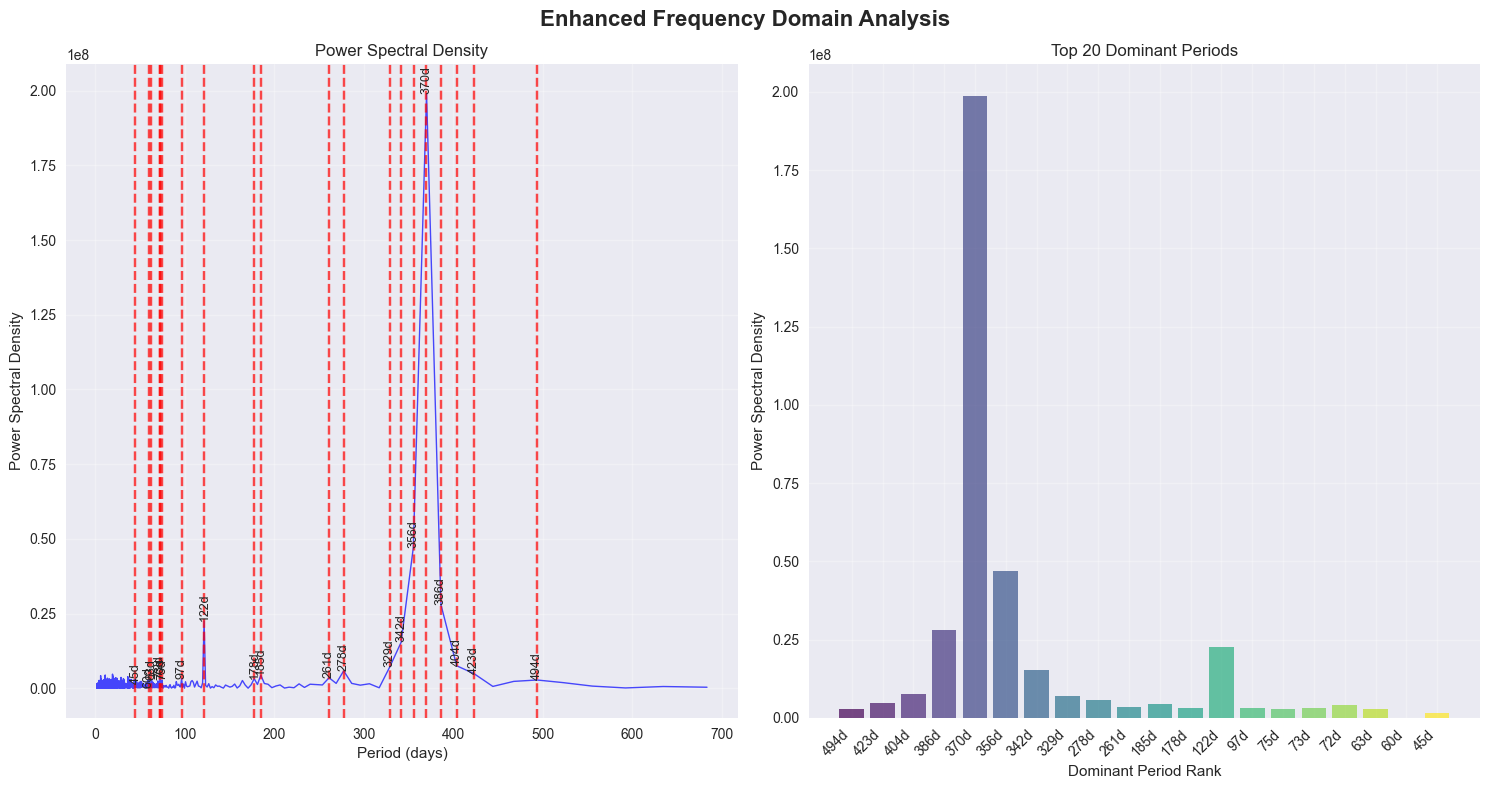

In [10]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_365 = temporal_analyzer.analyze_fft(
    detrend_window=365,  
    top_n=50,  
    period_range=(1, 730),
    return_n_dominant=20 
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_365,
    figsize=(15, 8),
    show_dominant=True,
    max_period=730,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 180
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 18 total dominant periods
   📊 Returning top 18 dominant periods:
      1. 363 days
      2. 178 days
      3. 123 days
      4. 121 days
      5. 119 days
      6. 108 days
      7. 97 days
      8. 73 days
      9. 60 days
      10. 50 days
      11. 32 days
      12. 29 days
      13. 24 days
      14. 19 days
      15. 16 days
      16. 15 days
      17. 7 days
      18. 6 days
   📊 Displaying 18 dominant periods in bar chart


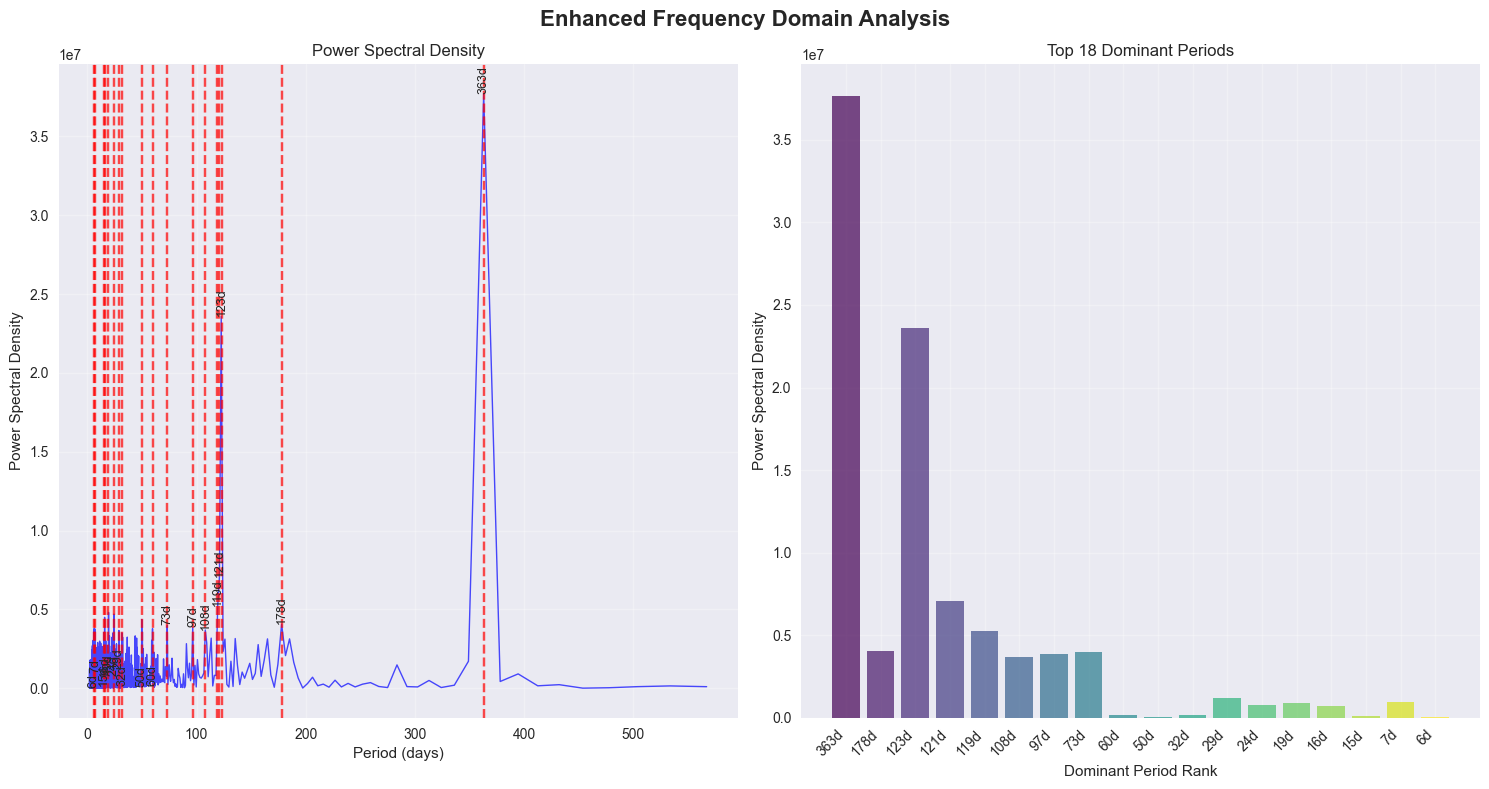

In [11]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_180 = temporal_analyzer.analyze_fft(
    detrend_window=180,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_180,
    figsize=(15, 8),
    show_dominant=True,
    max_period=600,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 90
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 18 total dominant periods
   📊 Returning top 18 dominant periods:
      1. 122 days
      2. 73 days
      3. 72 days
      4. 65 days
      5. 63 days
      6. 60 days
      7. 59 days
      8. 50 days
      9. 45 days
      10. 44 days
      11. 29 days
      12. 25 days
      13. 24 days
      14. 23 days
      15. 16 days
      16. 14 days
      17. 7 days
      18. 5 days
   📊 Displaying 18 dominant periods in bar chart


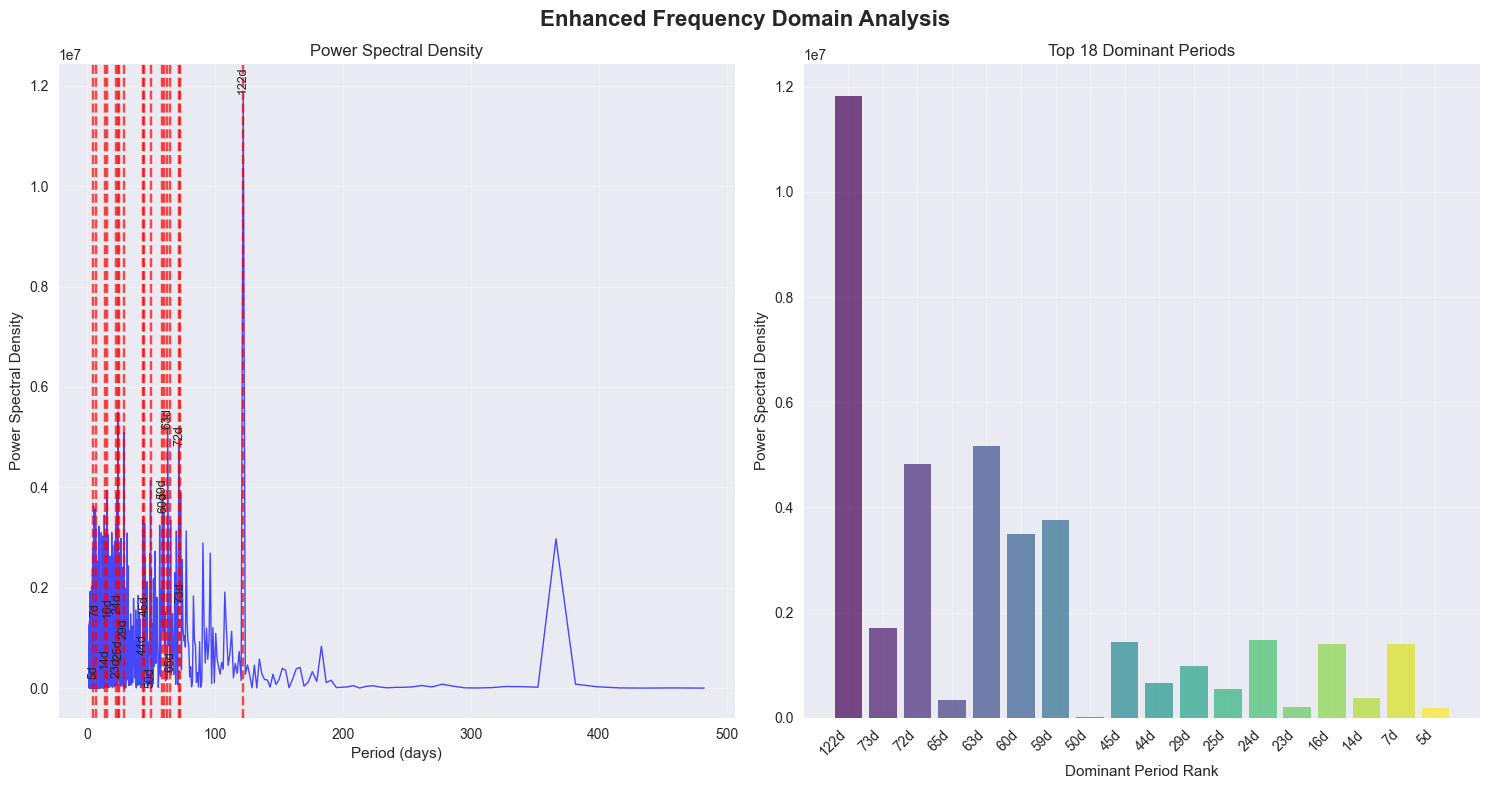

In [12]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_90 = temporal_analyzer.analyze_fft(
    detrend_window=90,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_90,
    figsize=(15, 8),
    show_dominant=True,
    max_period=500,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 30
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 12 total dominant periods
   📊 Returning top 12 dominant periods:
      1. 29 days
      2. 27 days
      3. 25 days
      4. 24 days
      5. 23 days
      6. 22 days
      7. 21 days
      8. 20 days
      9. 19 days
      10. 17 days
      11. 16 days
      12. 6 days
   📊 Displaying 12 dominant periods in bar chart


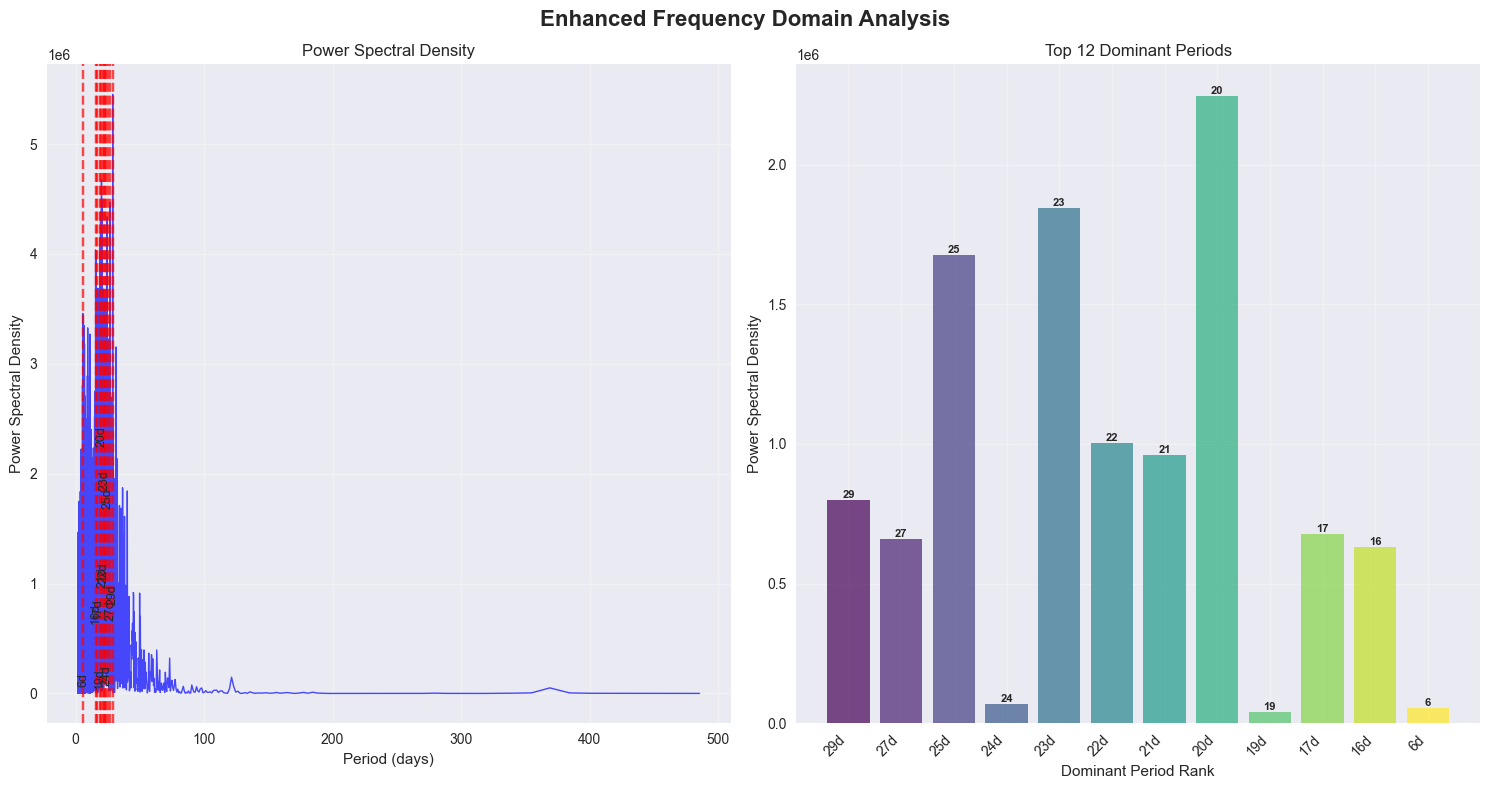

In [13]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_30 = temporal_analyzer.analyze_fft(
    detrend_window=30,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_30,
    figsize=(15, 8),
    show_dominant=True,
    max_period=500,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 15
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 9 total dominant periods
   📊 Returning top 9 dominant periods:
      1. 16 days
      2. 14 days
      3. 13 days
      4. 12 days
      5. 11 days
      6. 10 days
      7. 9 days
      8. 7 days
      9. 4 days
   📊 Displaying 9 dominant periods in bar chart


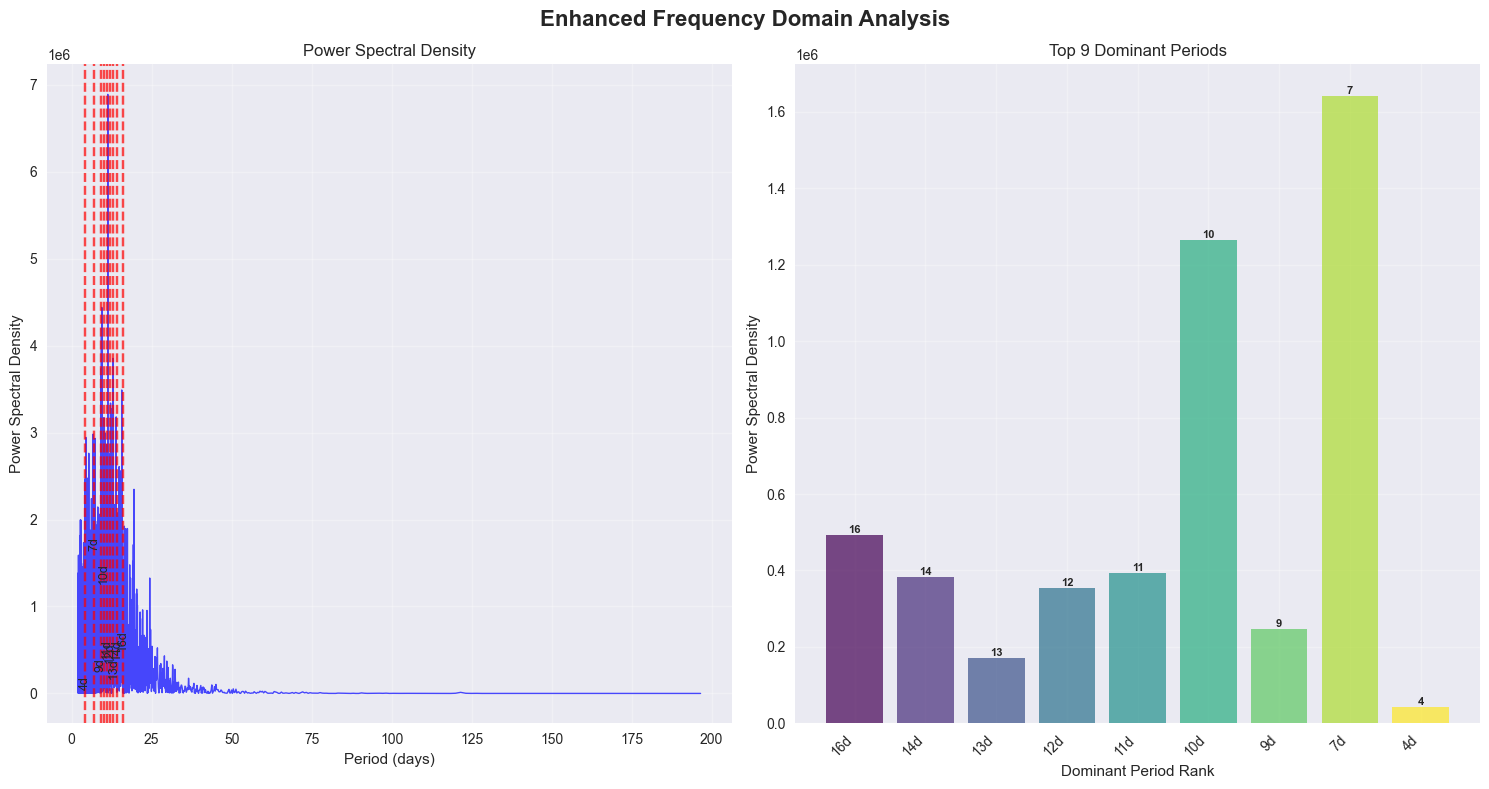

In [14]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_15 = temporal_analyzer.analyze_fft(
    detrend_window=15,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_15,
    figsize=(15, 8),
    show_dominant=True,
    max_period=200,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 7
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 4 total dominant periods
   📊 Returning top 4 dominant periods:
      1. 7 days
      2. 6 days
      3. 5 days
      4. 4 days
   📊 Displaying 4 dominant periods in bar chart


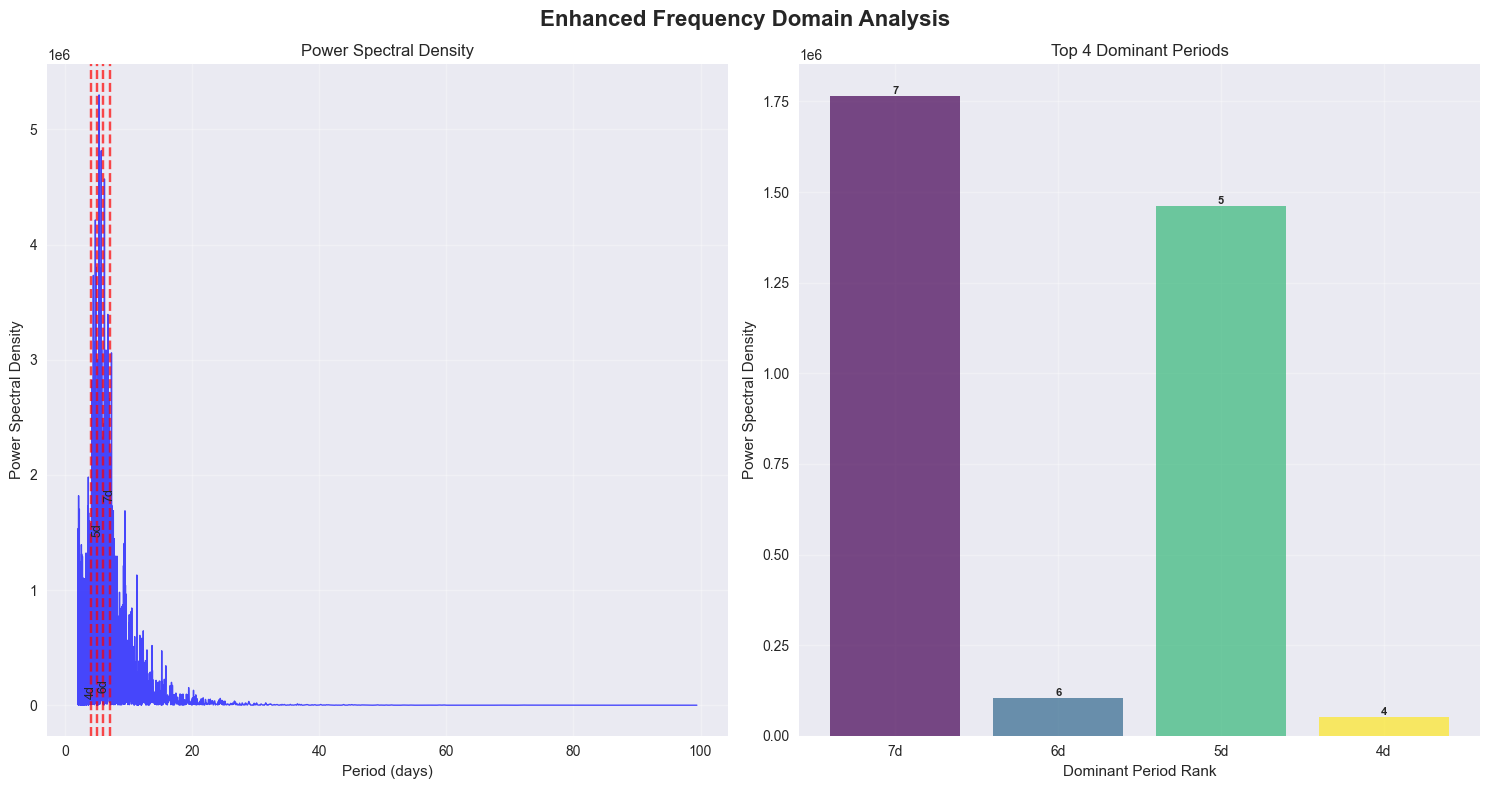

In [15]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_7 = temporal_analyzer.analyze_fft(
    detrend_window=7,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_7,
    figsize=(15, 8),
    show_dominant=True,
    max_period=100,  
    log_scale=False,
    bar_chart_periods=20 
)

### Wavelet Analysis

### MSTL Decomposition

In [16]:
analysis_periods = [7, 20, 122, 365]

mstl_results = temporal_analyzer.decompose_mstl(
    periods=analysis_periods,
    # MSTL parameters
    windows=None,  # Use default values from original paper
    lmbda=None,    
    iterate=3,     # Standard iteration count
    # STL parameters for fine-tuning
    robust=True,   # Handle outliers better
    seasonal_deg=1,  # Linear seasonal fit
    trend_deg=1      # Linear trend fit
)

print("\n🎯 MSTL Analysis Results:")
if mstl_results['success']:
    print("   ✅ MSTL decomposition completed successfully")
    print(f"   📊 Components available: trend, seasonal, residual")
    print(f"   📈 Trend shape: {mstl_results['trend'].shape}")
    print(f"   🌊 Seasonal shape: {mstl_results['seasonal'].shape}")  
    print(f"   📉 Residual shape: {mstl_results['resid'].shape}")
    print(f"   📤 Residual ready for Stationarity analysis")
else:
    print("   ❌ MSTL decomposition failed")
    print(f"   ⚠️ Error: {mstl_results['error']}")

📊 MSTL Decomposition
   - Periods: [7, 20, 122, 365]
   - Windows: None
   - Lambda: None
   - Iterations: 3
   - STL kwargs: {'robust': True, 'seasonal_deg': 1, 'trend_deg': 1}
   🔄 Applying log1p transformation (lmbda=None)
   ✅ MSTL decomposition completed successfully
   📊 Transform method: log1p
   📊 Components extracted: trend, seasonal, residual
   📤 Residual component available for Stationarity analysis

🎯 MSTL Analysis Results:
   ✅ MSTL decomposition completed successfully
   📊 Components available: trend, seasonal, residual
   📈 Trend shape: (9252,)
   🌊 Seasonal shape: (9252, 4)
   📉 Residual shape: (9252,)
   📤 Residual ready for Stationarity analysis


📊 MSTL Decomposition Visualization
✅ MSTL decomposition successful - proceeding with visualization

🎯 Decomposition Summary:
   📊 Periods used: [7, 20, 122, 365]
   🔄 Lambda (Box-Cox): None
   📈 Trend shape: (9252,)
   🌊 Seasonal shape: (9252, 4)
   📉 Residual shape: (9252,)


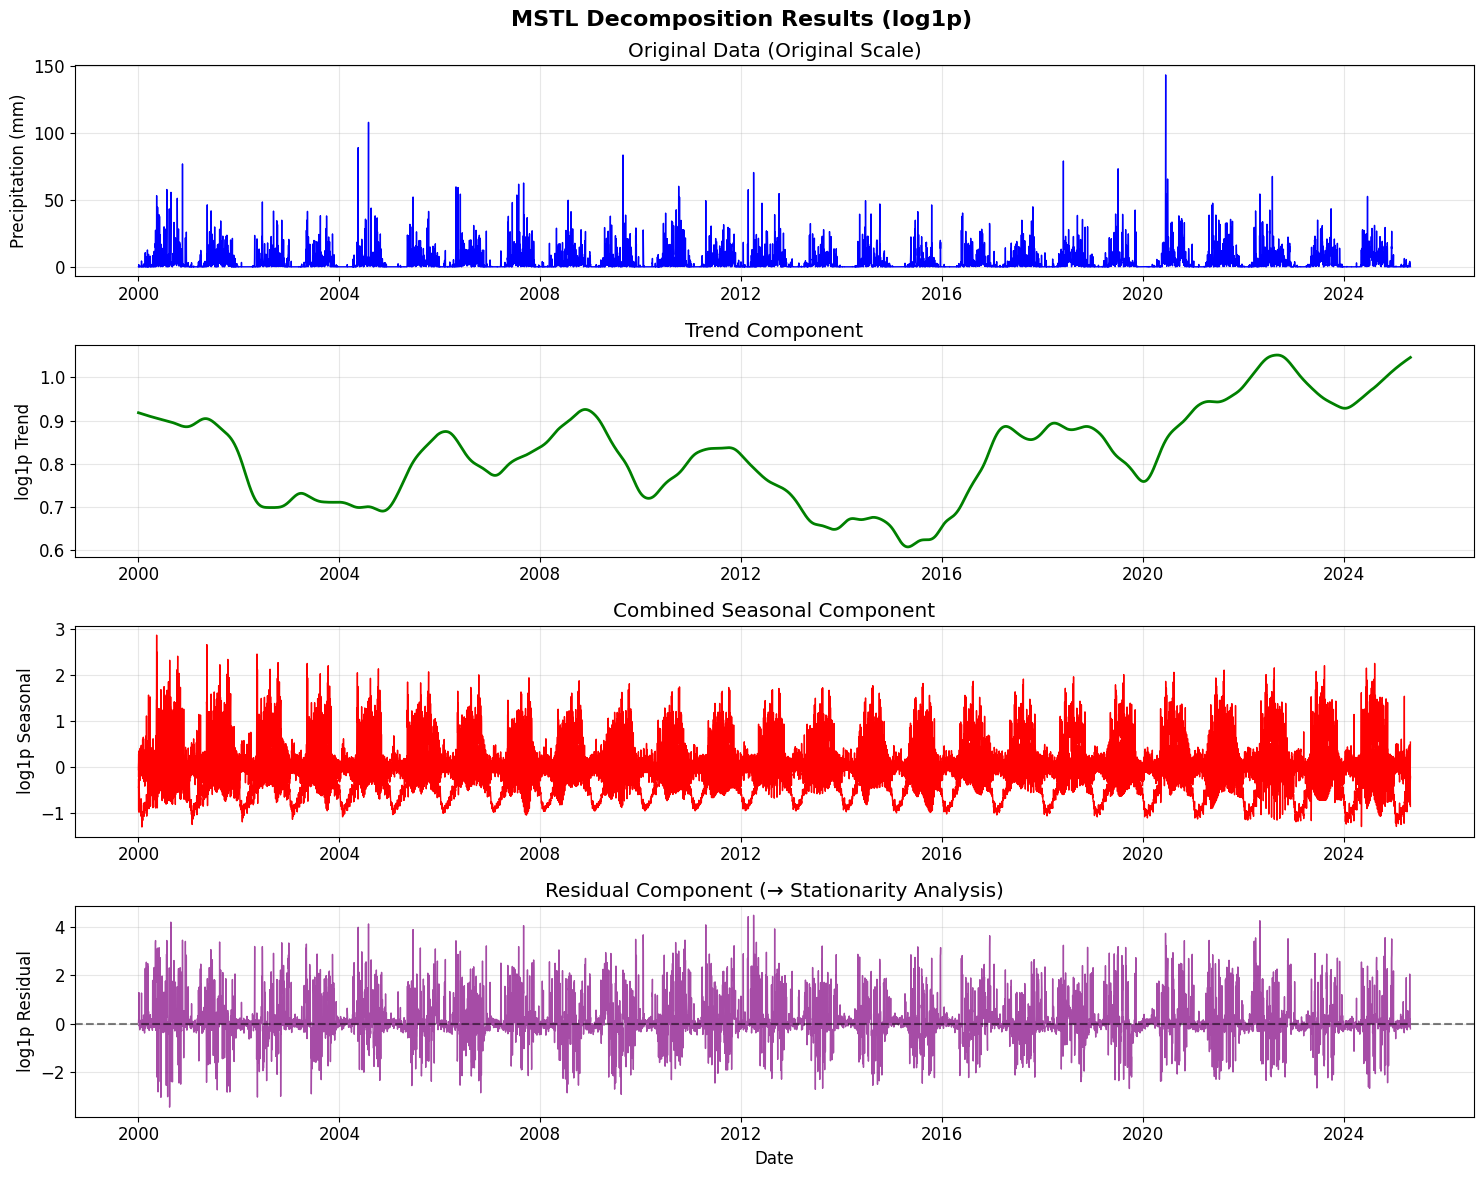

   📤 Residual component ready for Stationarity analysis
   🔄 Transform method used: log1p


In [17]:
# =============================================================================
# MSTL DECOMPOSITION VISUALIZATION
# =============================================================================

# Core libraries for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 12

print("📊 MSTL Decomposition Visualization")
print("=" * 50)

# Check if MSTL decomposition was successful
if mstl_results['success']:
    print("✅ MSTL decomposition successful - proceeding with visualization")
    
    # Display decomposition info
    print(f"\n🎯 Decomposition Summary:")
    print(f"   📊 Periods used: {mstl_results['periods']}")
    print(f"   🔄 Lambda (Box-Cox): {mstl_results['lmbda']}")
    print(f"   📈 Trend shape: {mstl_results['trend'].shape}")
    print(f"   🌊 Seasonal shape: {mstl_results['seasonal'].shape}")
    print(f"   📉 Residual shape: {mstl_results['resid'].shape}")
    
    # Check if fallback was used
    if mstl_results.get('fallback_used'):
        print(f"   ⚠️ Zero-handling fallback used: {mstl_results['zeros_adjusted']} zeros adjusted")
        print(f"   📊 Epsilon added: {mstl_results['epsilon_added']}")
    
    # Visualize decomposition
    temporal_analyzer.plot_decomposition(
        mstl_results=mstl_results,
        figsize=(15, 12),
        show_components=['trend', 'seasonal', 'resid'],
        original_scale=True
    )
    
else:
    print("❌ MSTL decomposition failed - cannot visualize")
    print(f"⚠️ Error: {mstl_results['error']}")

### Stationarity

🔍 COMPLETE STATIONARITY & AUTOCORRELATION ANALYSIS
   🎯 Theory-Driven Parameters Extracted:
      • Representative periods: [7, 20, 122, 365]
      • Max lags recommended: 200
      • Seasonal periods: [7, 20, 122, 365]
      • Parameter source: theory_driven

🔍 PHẦN 3: THEORY-DRIVEN STATIONARITY & AUTOCORRELATION DIAGNOSTICS
🎯 Mục tiêu: Theory-driven chẩn đoán với representative periods

🔍 BƯỚC 1: CHẨN ĐOÁN TÍNH DỪNG
   📊 ADF Test:
      - Statistic: -8.709252
      - P-value: 0.000000
      - Result: ✅ Stationary
   📊 KPSS Test:
      - Statistic: 0.072028
      - P-value: 0.100000
      - Result: ✅ Stationary
   🎯 Kết luận: ✅ STATIONARY


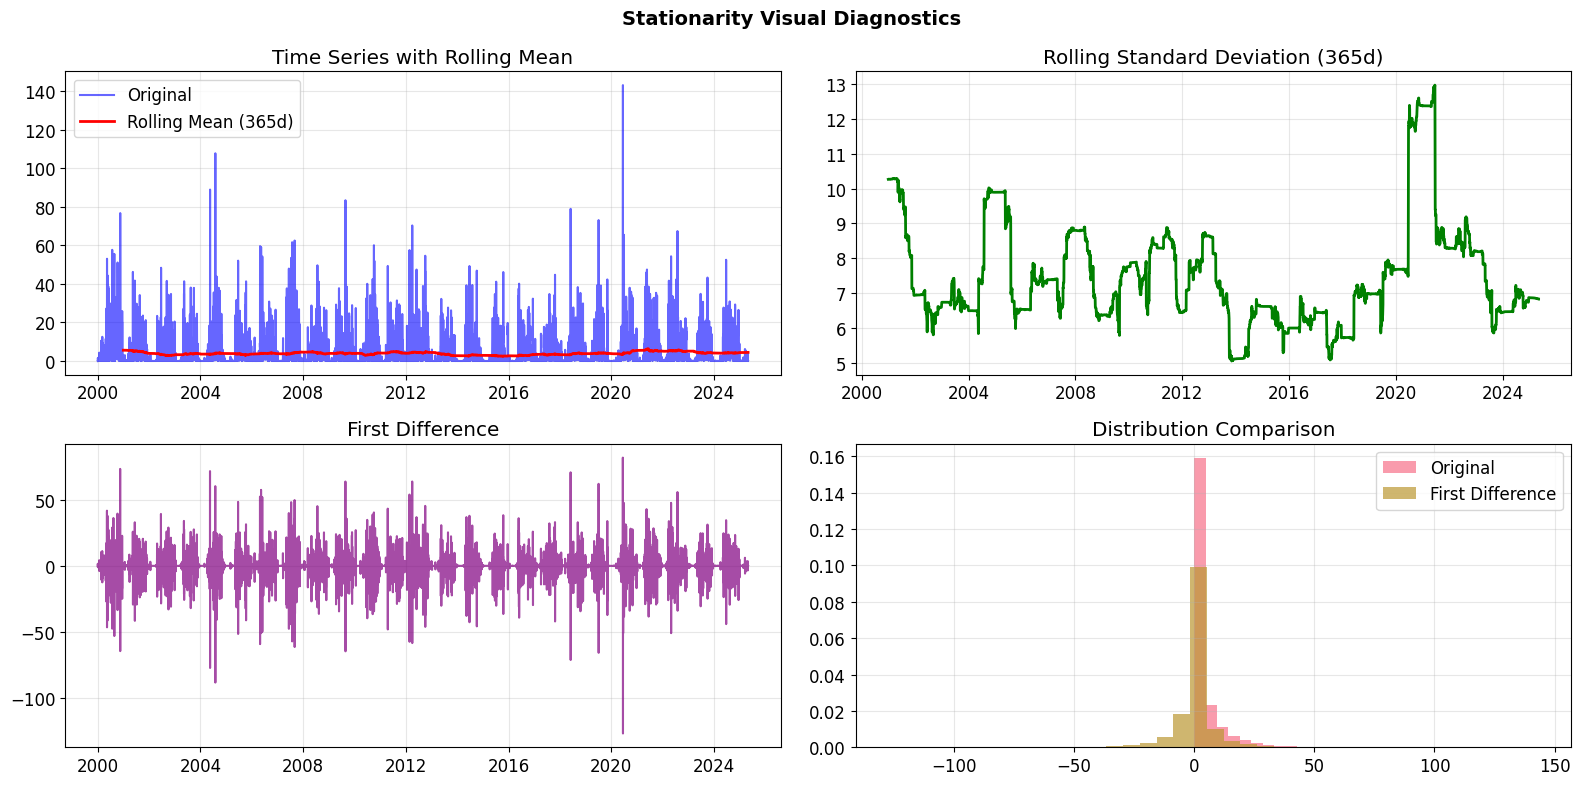


🔄 BƯỚC 2: PHÂN TÍCH TỰ TƯƠNG QUAN (THEORY-DRIVEN)
   🎯 Theory-driven max_lags: 200
      Source: theory_driven
      Based on max period: 365 + buffer: 91
   📈 ACF (Original Series):
      • Total significant lags: 160
      • Lags near representative periods: 32
   📈 PACF (Original Series):
      • Total significant lags: 44
      • Lags near representative periods: 18
   🎯 Theory-Driven SARIMA Parameter Selection:
      • ACF lags (p): [1, 2, 3, 4, 5]
      • PACF lags (q): [1, 2, 3, 4, 5]
      • Representative periods: [7, 20, 122, 365]
   📊 SARIMA Suggestions: ['SARIMA(3,1,3)x(1,1,1,365)', 'SARIMA(3,0,3)x(1,0,1,365)', 'SARIMA(3,1,3)x(1,1,1,122)']


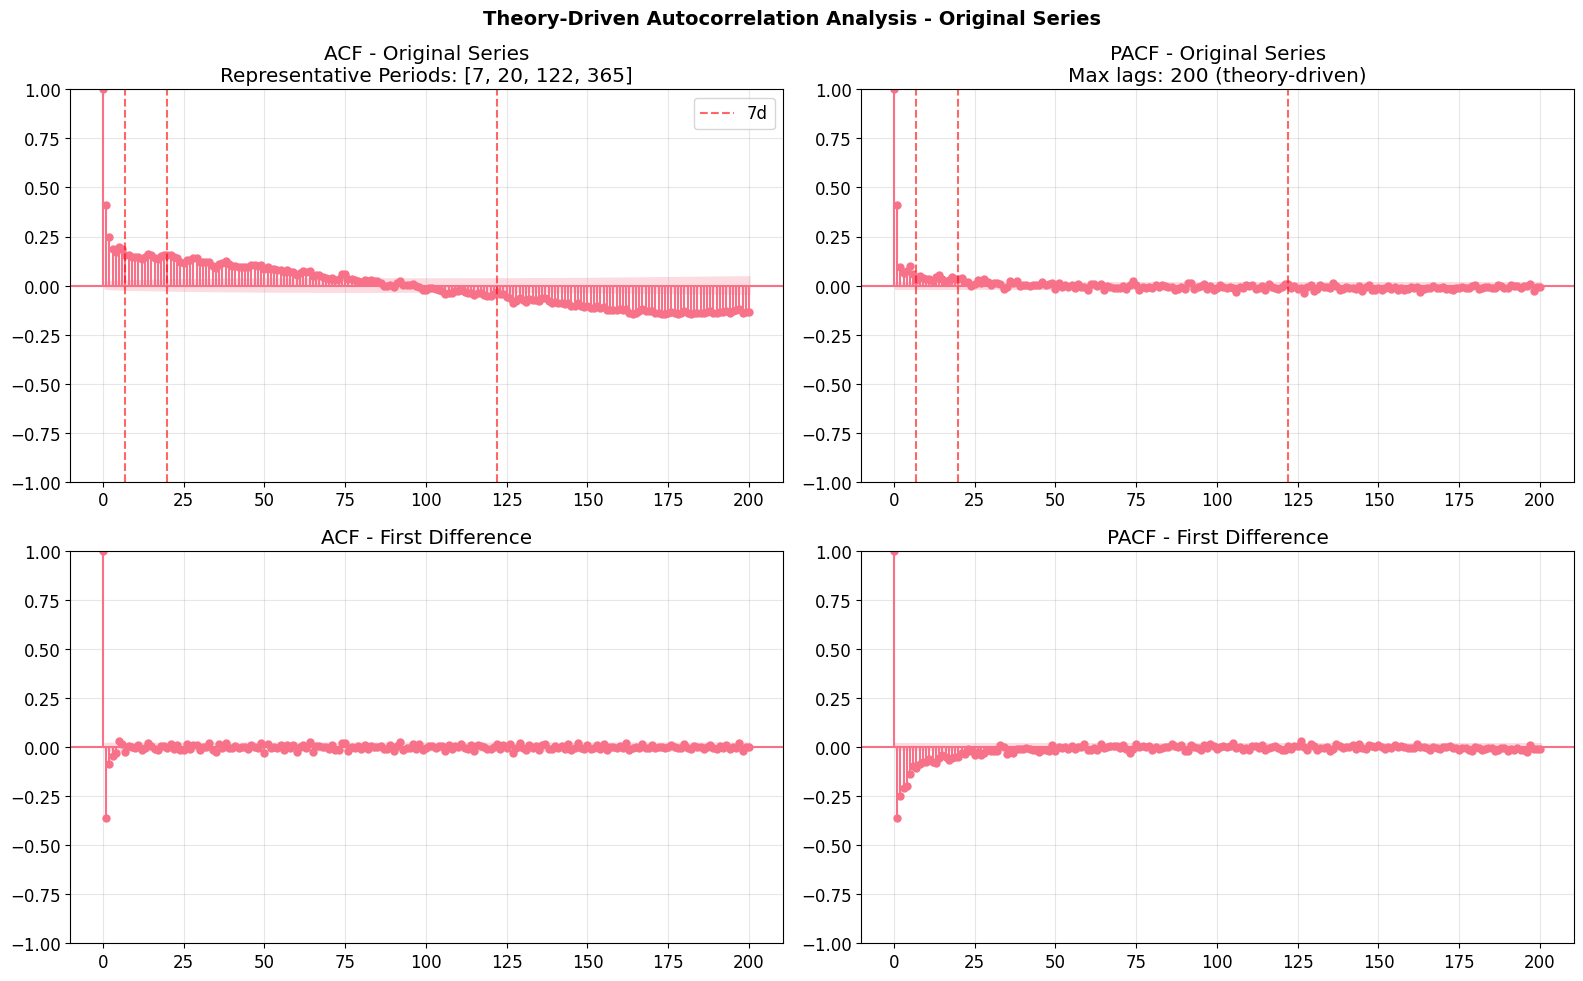


🧪 BƯỚC 3: CHẨN ĐOÁN RESIDUAL MSTL
🔍 Residual Diagnostics
   - Ljung-Box lags: 10
   - ACF lags: 40
   - Mean: 0.123163
   - Std: 0.819033
   ⚠️ Autocorrelation detected at 10 lags


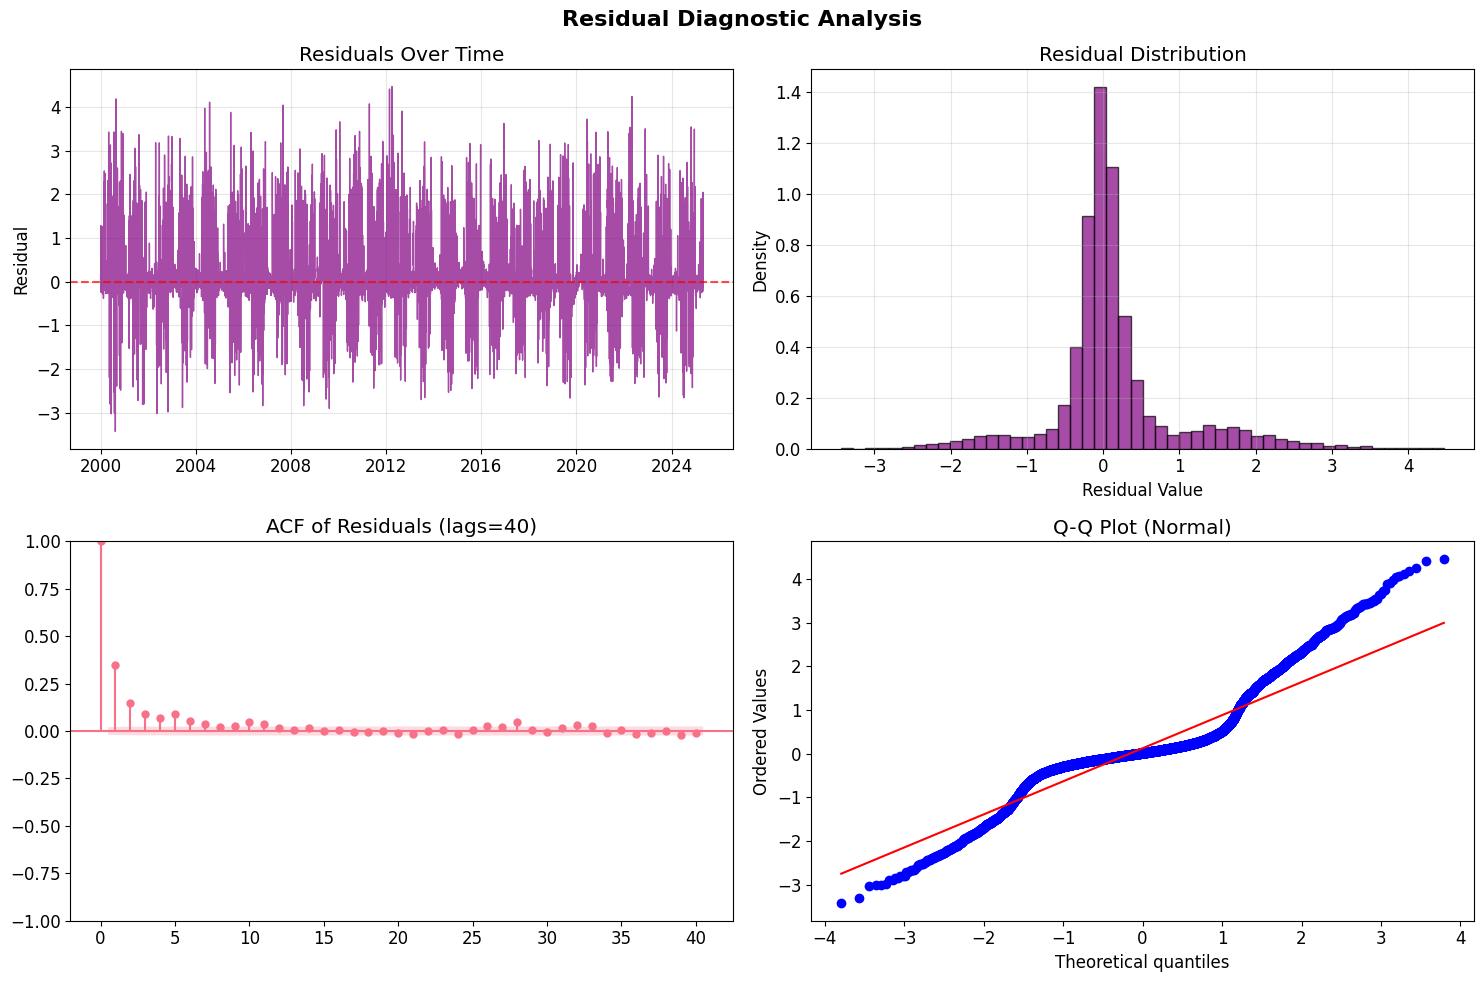


📊 Residual Summary:
   - Count: 9,252
   - Mean: 0.123163
   - Std: 0.819033
   - Skewness: 0.8237
   - Kurtosis: 3.6522
   📊 MSTL Quality: Poor
      • Significant structure in residuals
      • MSTL may be insufficient

📋 BƯỚC 4: TỔNG HỢP & KẾT LUẬN (THEORY-DRIVEN)
   📊 PHÁT HIỆN CHÍNH:
      🔹 Tính dừng: Stationary
      🔹 Cần sai phân: Không
      🔹 Methodology: theory_driven
      🔹 Lags quan trọng (top 5): [1, 2, 3, 4, 5]
      🔹 Theory-validated lags: 32
      🔹 Max lags used: 200 (theory_driven)
      🎯 Representative periods: [7, 20, 122, 365]

   💡 THEORY-DRIVEN MODEL RECOMMENDATIONS:
      • ARMA models suitable
      • SARIMA models for theory-driven seasonal patterns
      • Representative periods: [7, 20, 122, 365]
      • All seasonal periods: [7, 20, 122, 365]
      • Additional AR/MA terms may be needed
      • Theory-driven analysis: 32 lags validated against representative periods
✅ Complete analysis finished!


In [18]:
from src.analysis.Stationarity import StationarityAutocorrelationAnalyzer

print("🔍 COMPLETE STATIONARITY & AUTOCORRELATION ANALYSIS")
print("=" * 55)

# Check prerequisites
if 'mstl_results' in locals() and mstl_results.get('success'):
    
    # Initialize analyzer
    analyzer = StationarityAutocorrelationAnalyzer(
        df=df,
        target_col='Lượng mưa',
        date_col='Ngày',
        mstl_results=mstl_results,
        representative_periods=analysis_periods
    )
    
    # ✅ ONE METHOD CALL - RUNS EVERYTHING!
    complete_results = analyzer.analyze()
    
    print("✅ Complete analysis finished!")
    
    # Results contain:
    # - stationarity tests (ADF, KPSS)
    # - autocorrelation analysis (ACF, PACF)  
    # - residual diagnostics (if MSTL provided)
    # - synthesis & recommendations
    
else:
    print("❌ MSTL results not available")

## Cross-Correlation & Multicollinearity Analysis

🚀 STARTING COMPREHENSIVE CORRELATION ANALYSIS
🔍 CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa
   🔢 Total Features: 20
   📈 Predictor Features: 19

📋 6. CORRELATION ANALYSIS INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 6 features
   - Humidity: 5 features
   - Wind: 6 features
   - Pressure_Radiation: 2 features
   - Precipitation: 1 features

📅 2. TEMPORAL CORRELATION DYNAMICS

🔍 3. MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
            Feature     VIF_Score    Category Risk_Level
Nhiệt độ bầu ướt 2m 154387.023484 Temperature       High
      Điểm sương 2m 113529.370568 Temperature       High
        Nhiệt độ 2m  74977.814798 Temperature       High
      Tốc độ gió 2m    611.690068        Wind       High
     Tốc độ gió 10m    584.487676        Wind       High
 Độ ẩm tuyệt đối 2m    278.682109    Humidity       High
 Độ ẩm tương đối 2m    242.9

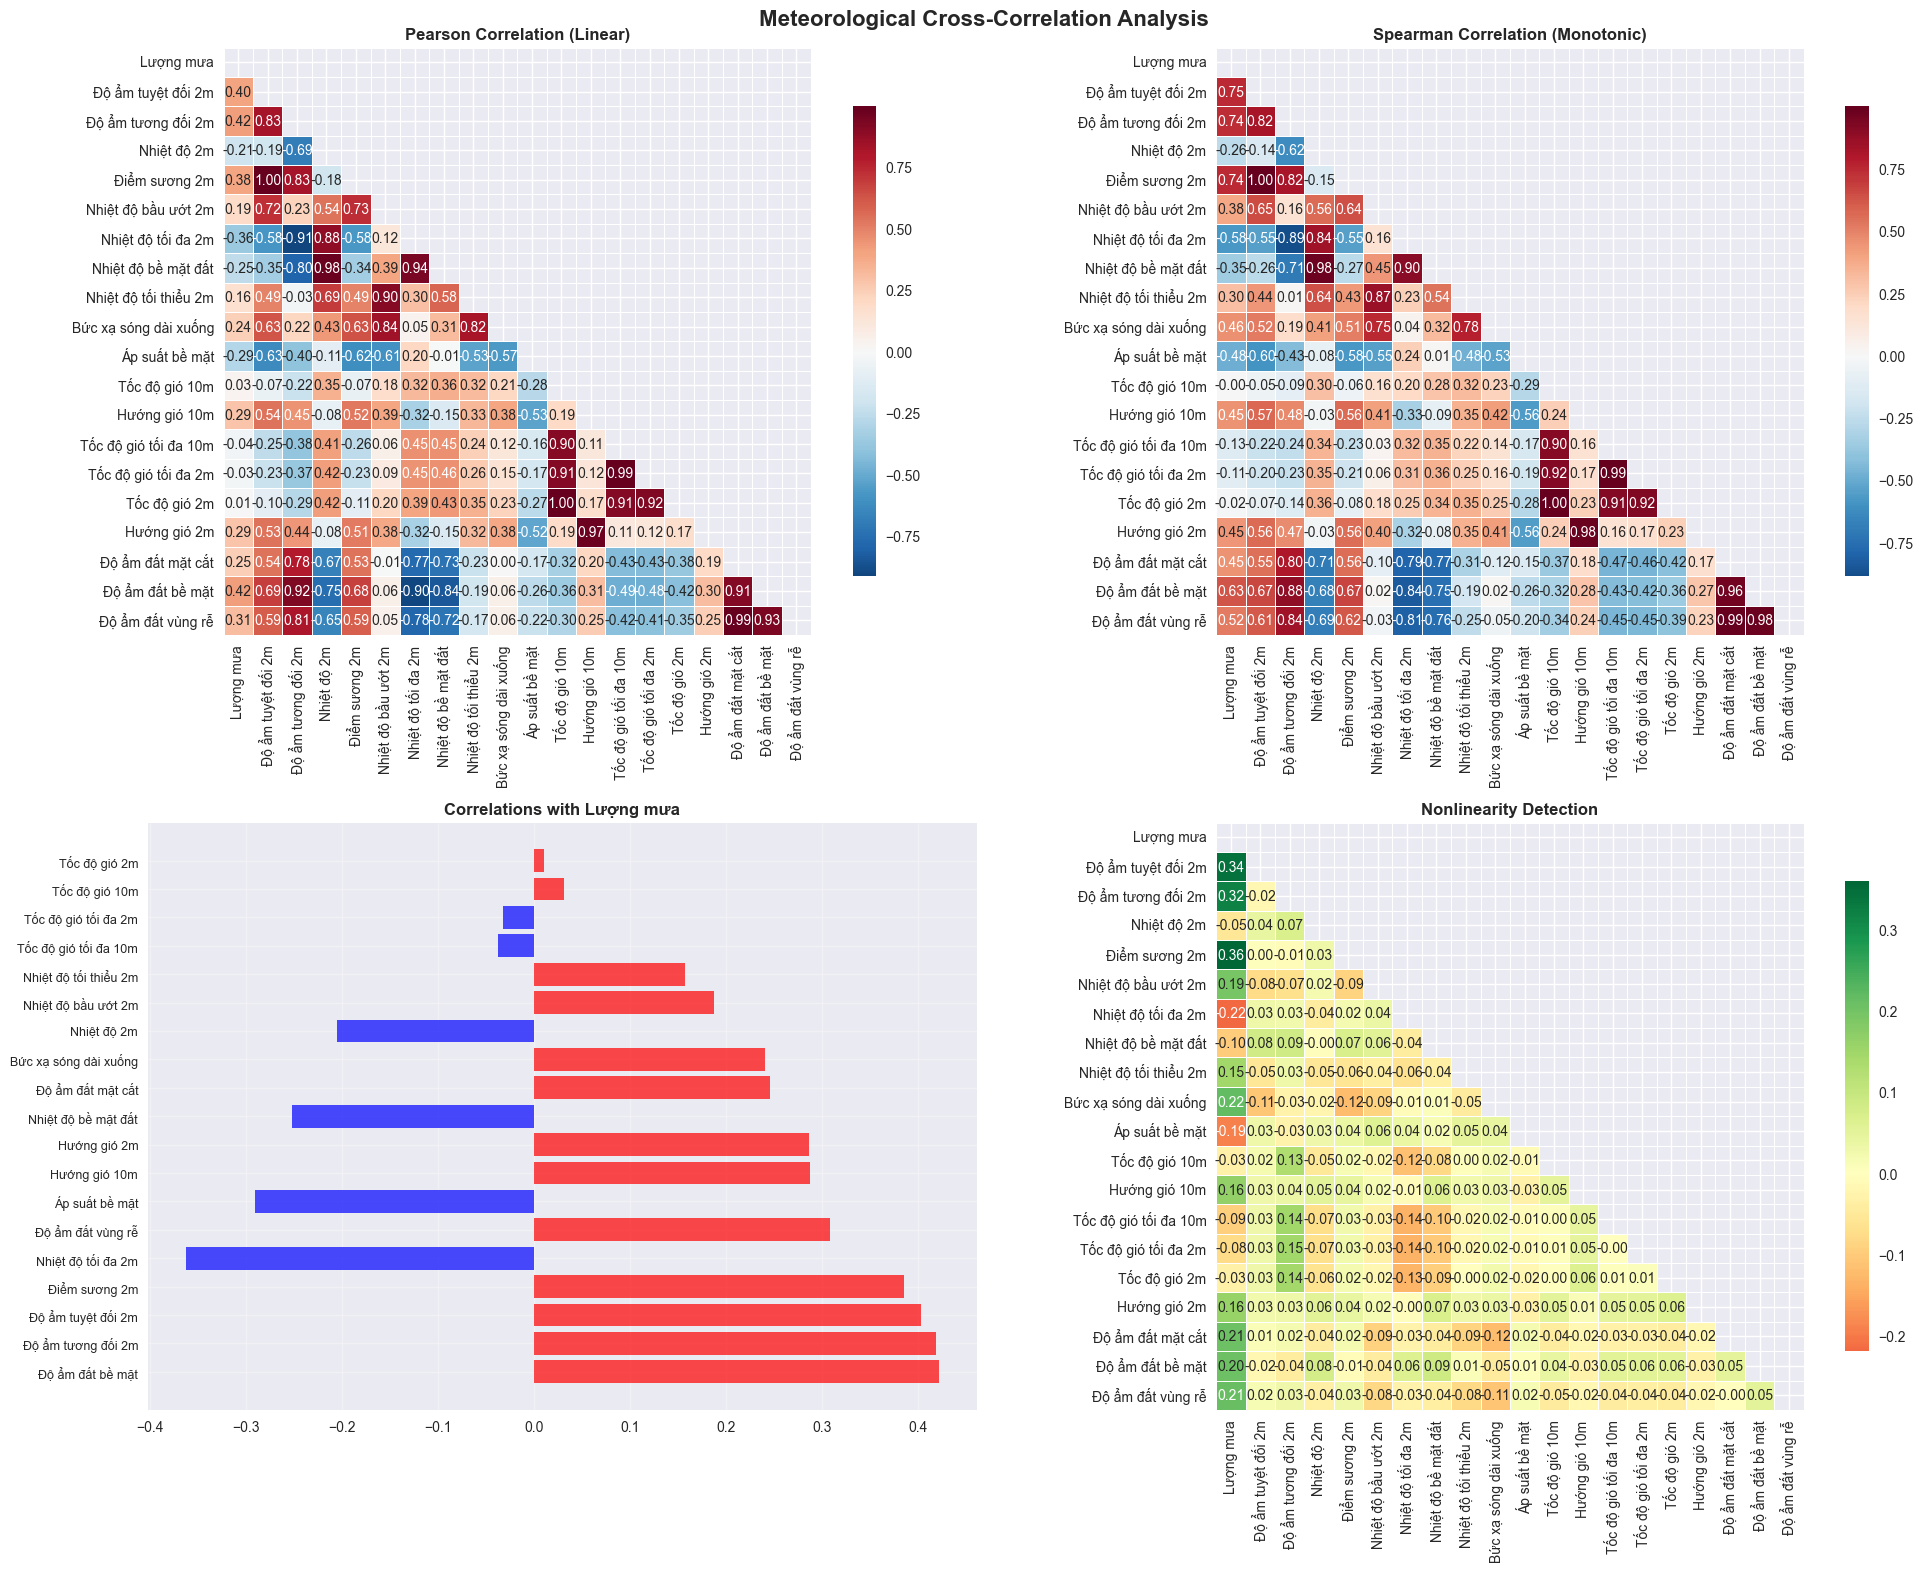

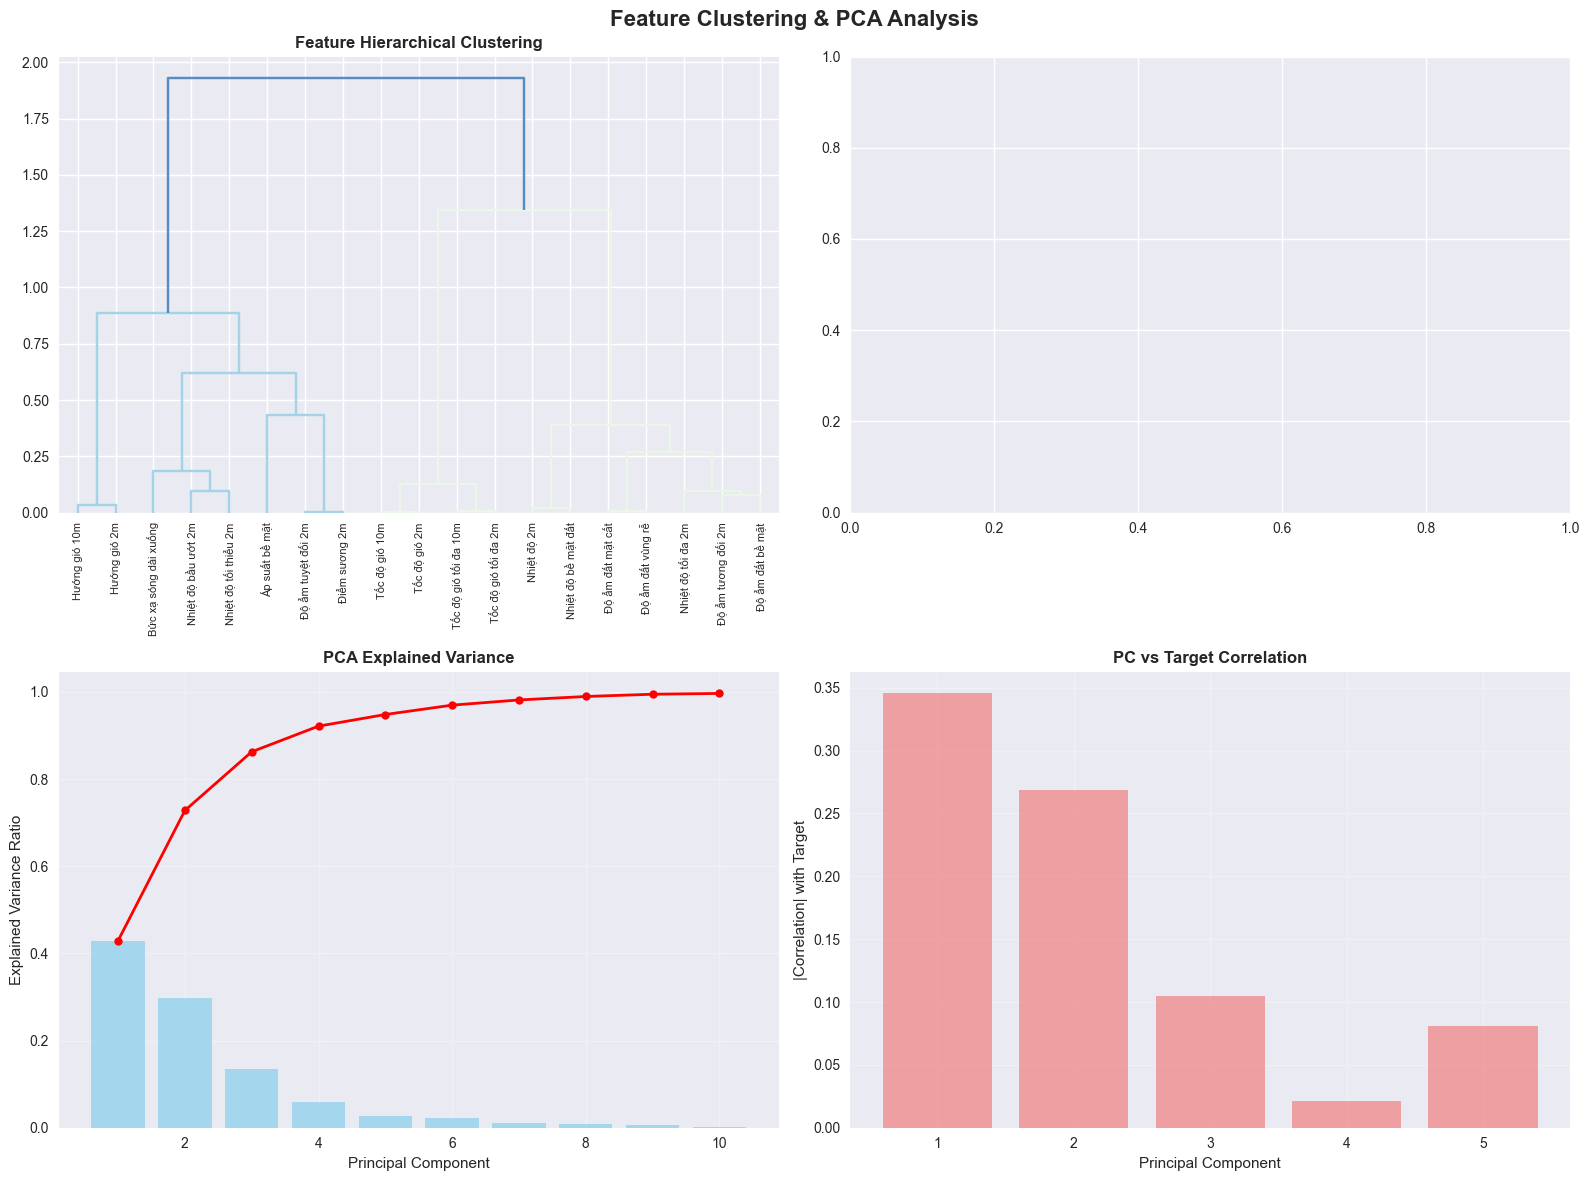

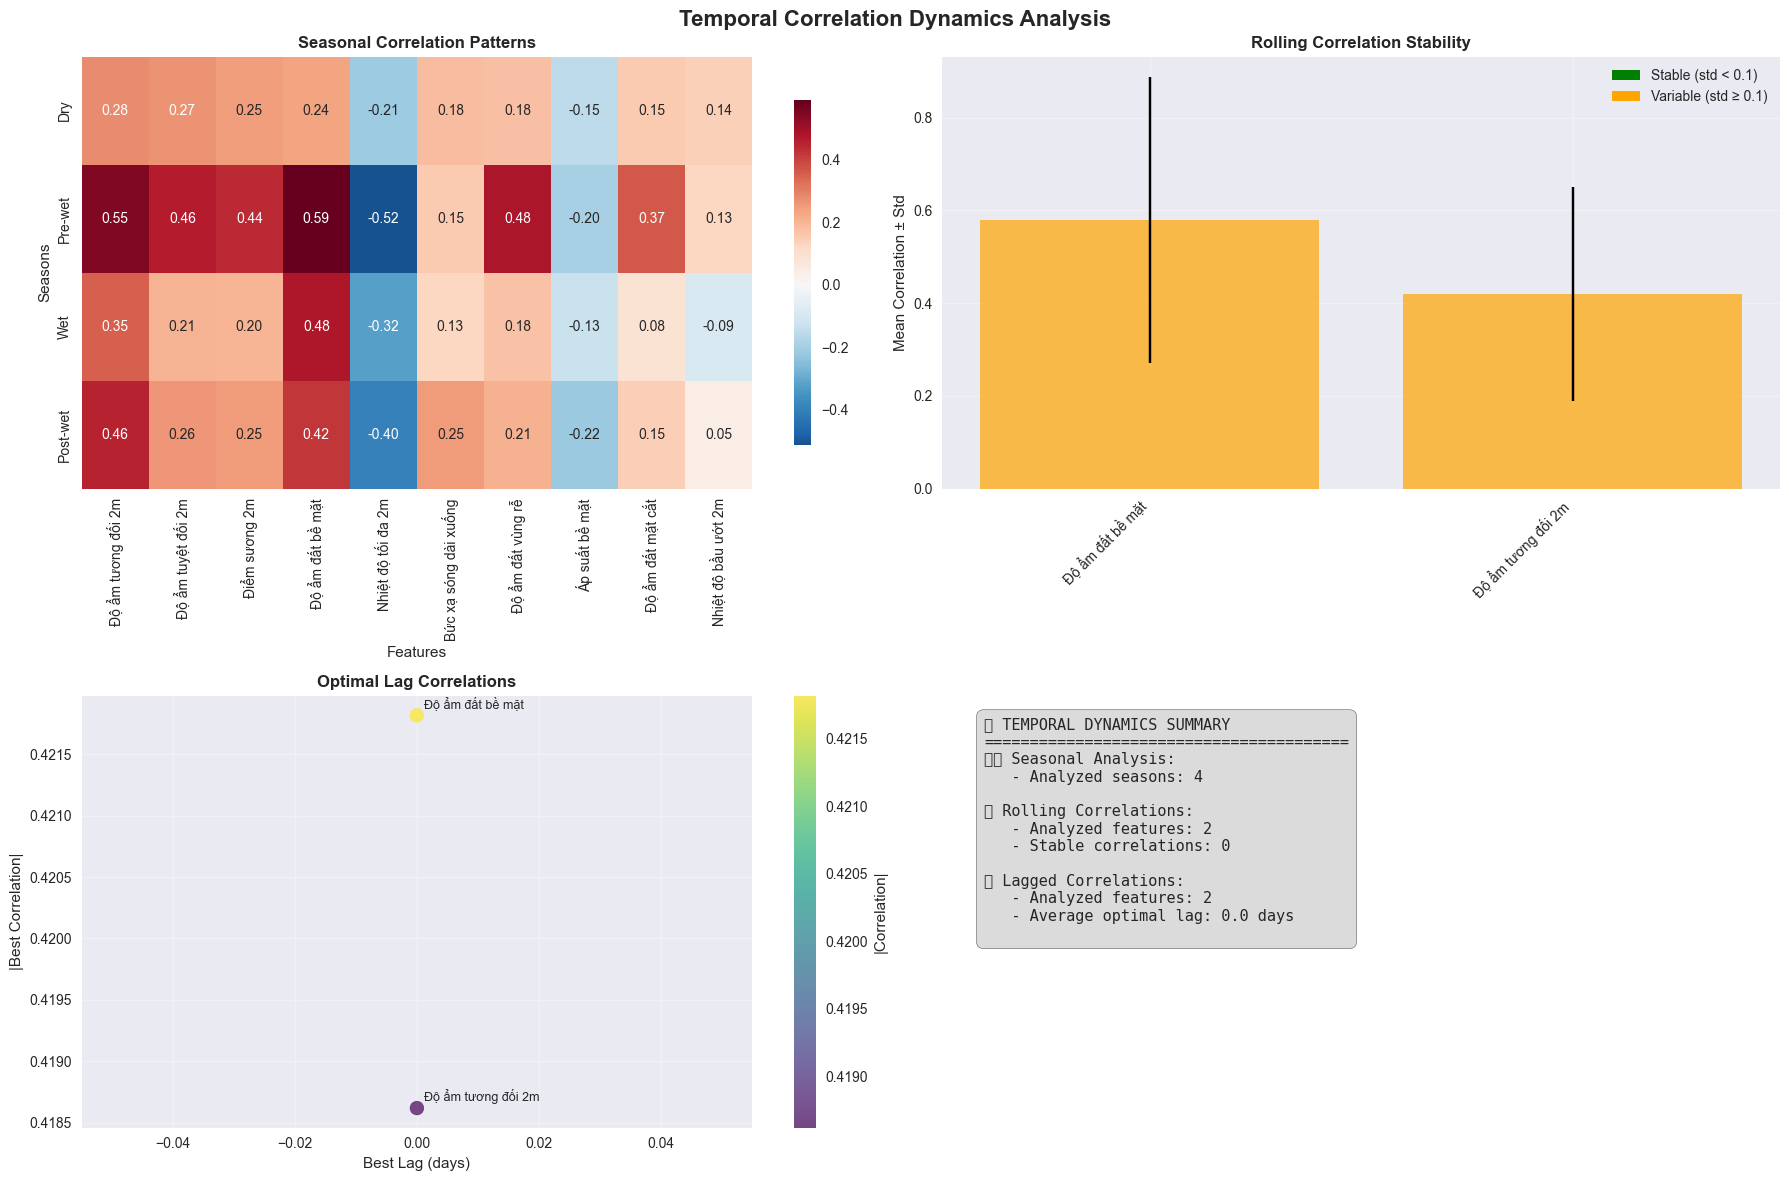

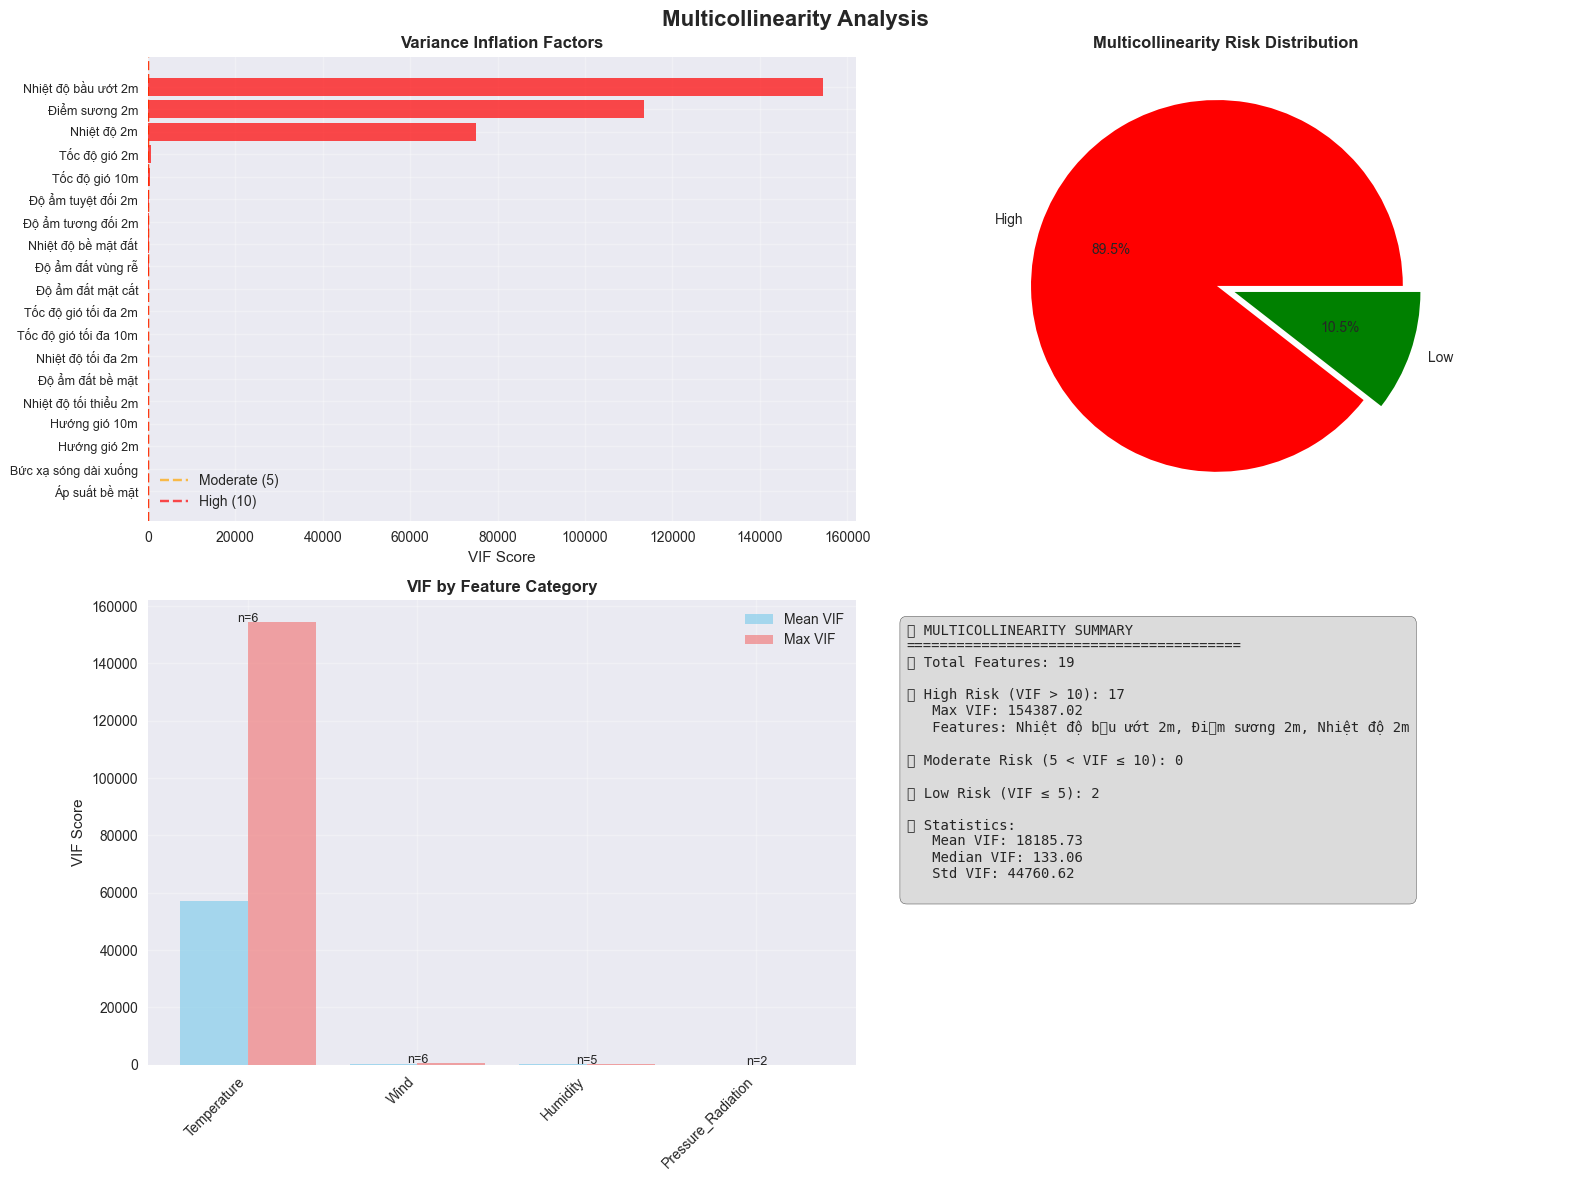

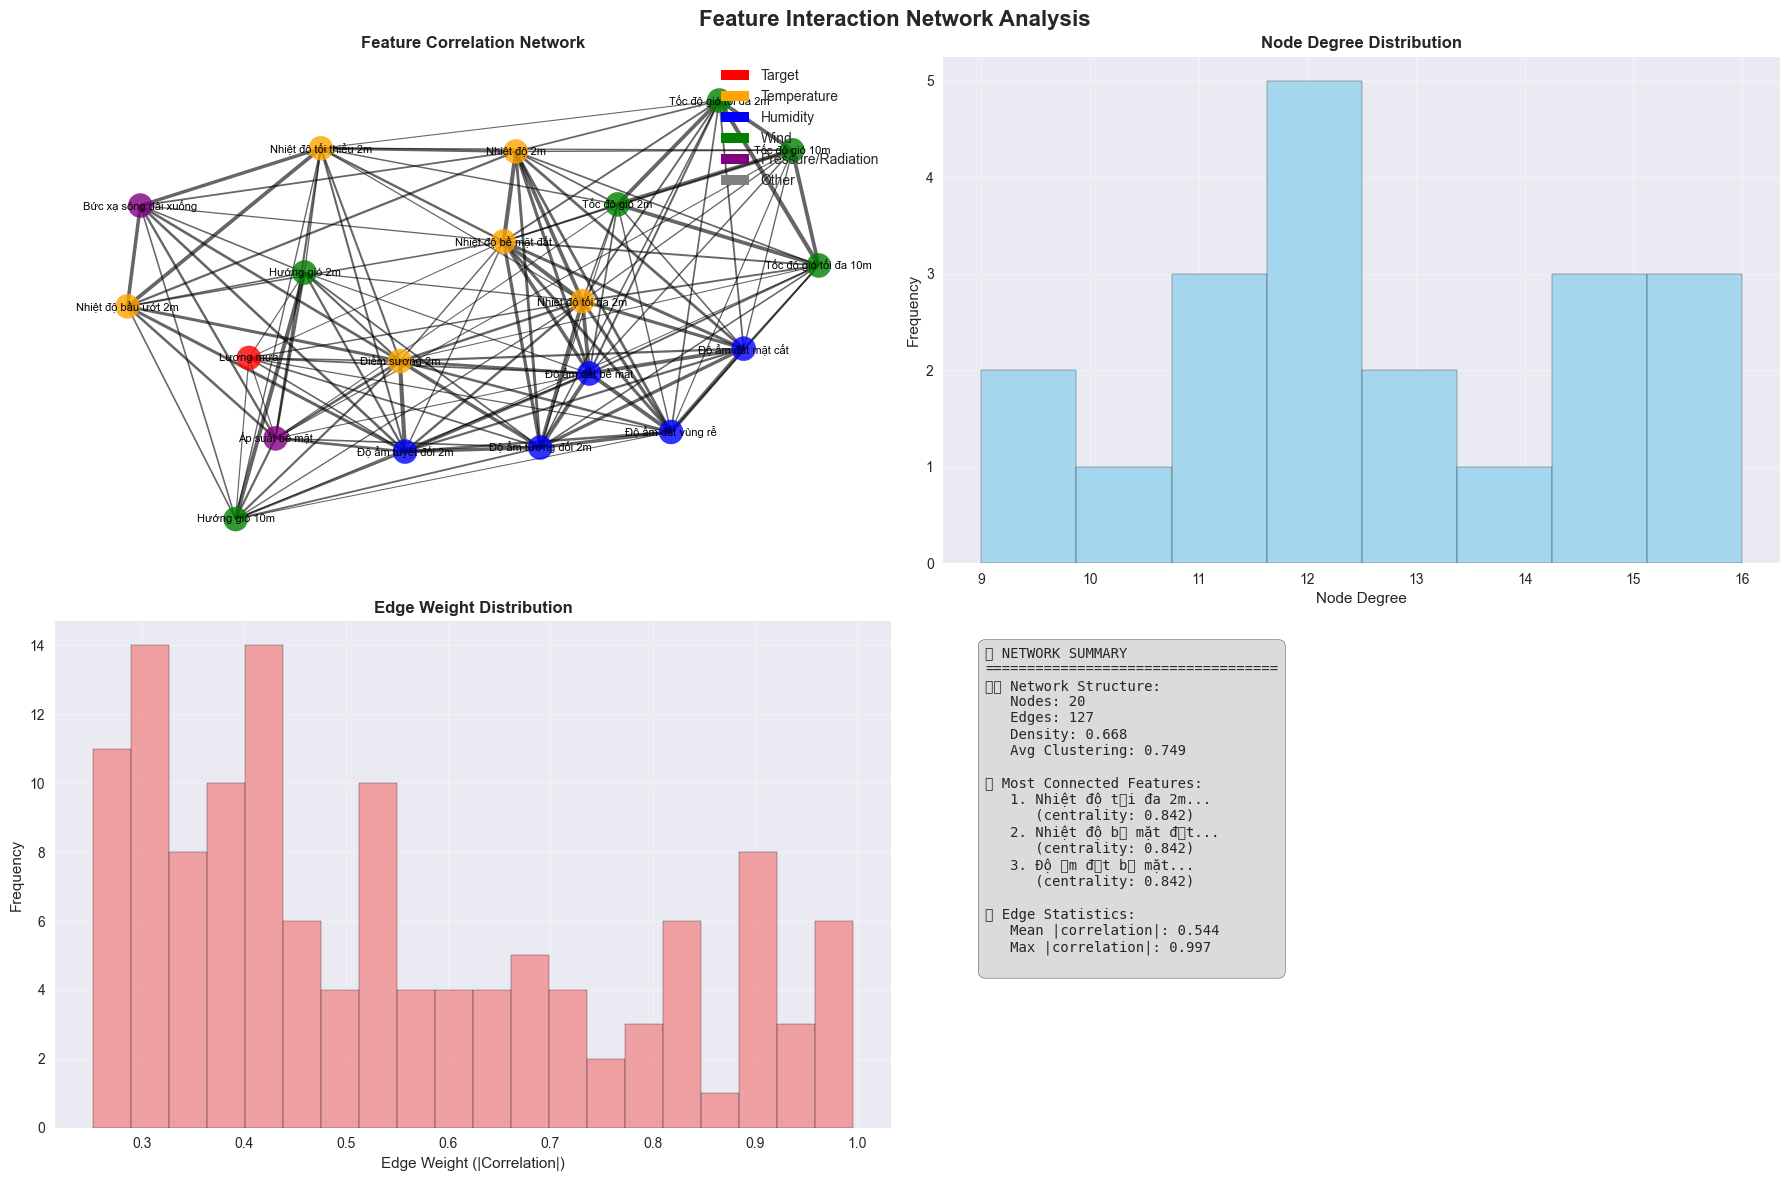


✅ CORRELATION ANALYSIS COMPLETED


In [19]:
from src.analysis.CorrelationAnalysis import analyze_correlations

# Chạy toàn bộ pipeline với visualization
results = analyze_correlations(df, target_col='Lượng mưa', date_col='Ngày', include_visualization=True)

# Feature Engineering

In [20]:
# Import feature engineering utilities
from src.featurengineering.utils import (
    select_features, create_temporal_features, create_lag_features,
    create_rolling_features, create_interaction_features, 
    handle_missing_values, validate_feature_quality,
    apply_feature_engineering_steps
)

print("✅ Feature Engineering modules imported successfully")

✅ Feature Engineering modules imported successfully


## Feature Selection

In [31]:
# Define selected features (same as manual approach)
selected_features = [
    'Nhiệt độ tối đa 2m',      # T2M_MAX
    'Nhiệt độ tối thiểu 2m',    # T2M_MIN
    'Độ ẩm tương đối 2m',       # RH2M
    'Độ ẩm đất bề mặt',         # GWETTOP
    'Hướng gió 10m',            # WD10M
    'Áp suất bề mặt',           # PS
    'Bức xạ sóng dài xuống'     # ALLSKY_SFC_LW_DWN
]

# Use module function for feature selection
df_selected = select_features(
    df=df,
    features_to_keep=selected_features,
    target_col='Lượng mưa',
    date_col='Ngày',
    keep_essential=True
)

print(f"Selected features: {selected_features}")

📊 SELECTING FEATURES
   Features to select: 7
   Original shape: (9252, 23)
   Selected shape: (9252, 9)
   ✅ Feature selection completed
Selected features: ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống']


## Temporal feature

In [32]:
# Create temporal features using module function
temporal_features_to_create = [
    'Year', 'Month', 'DayofMonth', 'DayofYear',
    'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
    'Is_Wet_Season'
]

df_selected = create_temporal_features(
    df=df_selected,
    date_col='Ngày',
    features_to_create=temporal_features_to_create,
    wet_season_months=[5, 6, 7, 8, 9, 10]  # May-November for HCMC
)

# Display sample of new features (same as manual)
print("\n📊 Sample of new time features:")
print(df_selected[['Ngày', 'Year', 'Month', 'DayofMonth', 'DayofYear',
                   'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
                   'Is_Wet_Season']].head(10))

print(f"\n🌧️ Wet Season Distribution:")
print(df_selected['Is_Wet_Season'].value_counts())

🕒 CREATING TEMPORAL FEATURES
   ✅ Created 9 temporal features
   Dataset shape: (9252, 18)

📊 Sample of new time features:
        Ngày  Year  Month  DayofMonth  DayofYear  Month_sin  Month_cos  \
0 2000-01-01  2000      1           1          1        0.5   0.866025   
1 2000-01-02  2000      1           2          2        0.5   0.866025   
2 2000-01-03  2000      1           3          3        0.5   0.866025   
3 2000-01-04  2000      1           4          4        0.5   0.866025   
4 2000-01-05  2000      1           5          5        0.5   0.866025   
5 2000-01-06  2000      1           6          6        0.5   0.866025   
6 2000-01-07  2000      1           7          7        0.5   0.866025   
7 2000-01-08  2000      1           8          8        0.5   0.866025   
8 2000-01-09  2000      1           9          9        0.5   0.866025   
9 2000-01-10  2000      1          10         10        0.5   0.866025   

   DayOfYear_sin  DayOfYear_cos  Is_Wet_Season  
0       0.017

## Lag and Rolling window Engineering


### for Target Variable

In [33]:
# A. Target Variable Lag Features
print("🎯 Creating Target Variable Lag Features...")

df_selected = create_lag_features(
    df=df_selected,
    columns_to_lag='Lượng mưa',
    lags=[1, 2, 3, 4, 5, 7, 20, 30],
    suffix='lag'
)

🎯 Creating Target Variable Lag Features...
⏰ CREATING LAG FEATURES
   ✅ Created 8 lag features
   Columns lagged: ['Lượng mưa']
   Lag periods: [1, 2, 3, 4, 5, 7, 20, 30]
   Dataset shape: (9252, 26)


In [34]:
# B. Target Variable Rolling Features
print("🎯 Creating Target Variable Rolling Features...")

# Rolling sum features (cumulative rainfall)
df_selected = create_rolling_features(
    df=df_selected,
    columns_to_roll='Lượng mưa',
    windows=[7, 20],
    stats=['sum', 'mean', 'max', 'std']
)

🎯 Creating Target Variable Rolling Features...
🪟 CREATING ROLLING FEATURES
   ✅ Created 8 rolling features
   Columns: ['Lượng mưa']
   Windows: [7, 20]
   Statistics: ['sum', 'mean', 'max', 'std']
   Dataset shape: (9252, 34)


### for Feature

In [35]:
# C. Temperature Features
print("🌡️ Creating Temperature Features...")

temp_vars = ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m']

# Temperature lag features
for var in temp_vars:
    df_selected = create_lag_features(
        df=df_selected,
        columns_to_lag=var,
        lags=[1],
        suffix='lag'
    )

# Temperature rolling features
for var in temp_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7, 20],
        stats=['mean']
    )

🌡️ Creating Temperature Features...
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Nhiệt độ tối đa 2m']
   Lag periods: [1]
   Dataset shape: (9252, 35)
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Nhiệt độ tối thiểu 2m']
   Lag periods: [1]
   Dataset shape: (9252, 36)
🪟 CREATING ROLLING FEATURES
   ✅ Created 2 rolling features
   Columns: ['Nhiệt độ tối đa 2m']
   Windows: [7, 20]
   Statistics: ['mean']
   Dataset shape: (9252, 38)
🪟 CREATING ROLLING FEATURES
   ✅ Created 2 rolling features
   Columns: ['Nhiệt độ tối thiểu 2m']
   Windows: [7, 20]
   Statistics: ['mean']
   Dataset shape: (9252, 40)


In [36]:
# D. Humidity Features
print("💧 Creating Humidity Features...")

humidity_vars = ['Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt']

# Humidity lag features
for var in humidity_vars:
    df_selected = create_lag_features(
        df=df_selected,
        columns_to_lag=var,
        lags=[1],
        suffix='lag'
    )

# Humidity rolling features
for var in humidity_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7, 20],
        stats=['mean', 'std']
    )

💧 Creating Humidity Features...
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Độ ẩm tương đối 2m']
   Lag periods: [1]
   Dataset shape: (9252, 41)
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Độ ẩm đất bề mặt']
   Lag periods: [1]
   Dataset shape: (9252, 42)
🪟 CREATING ROLLING FEATURES
   ✅ Created 4 rolling features
   Columns: ['Độ ẩm tương đối 2m']
   Windows: [7, 20]
   Statistics: ['mean', 'std']
   Dataset shape: (9252, 46)
🪟 CREATING ROLLING FEATURES
   ✅ Created 4 rolling features
   Columns: ['Độ ẩm đất bề mặt']
   Windows: [7, 20]
   Statistics: ['mean', 'std']
   Dataset shape: (9252, 50)
✅ All Lag & Rolling Window Features completed:
   Final dataset shape: (9252, 50)
   Missing values created: 326 (due to lag/rolling operations)


In [38]:
# D. Humidity Features
print("💧 Creating Remaining Features...")

humidity_vars = ['Áp suất bề mặt', 'Bức xạ sóng dài xuống' ]

# Humidity rolling features
for var in humidity_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7],
        stats=['mean']
    )

💧 Creating Remaining Features...
🪟 CREATING ROLLING FEATURES
   ✅ Created 1 rolling features
   Columns: ['Áp suất bề mặt']
   Windows: [7]
   Statistics: ['mean']
   Dataset shape: (9252, 51)
🪟 CREATING ROLLING FEATURES
   ✅ Created 1 rolling features
   Columns: ['Bức xạ sóng dài xuống']
   Windows: [7]
   Statistics: ['mean']
   Dataset shape: (9252, 52)


### Validate Feature

In [39]:
# Validate engineered features quality
print("🔍 Validating Feature Quality...")

validation_results = validate_feature_quality(
    df=df_selected,
    target_col='Lượng mưa',
    correlation_threshold=0.05,
    variance_threshold=0.01
)

# Display validation summary
print(validation_results['summary'])

🔍 Validating Feature Quality...
✅ VALIDATING FEATURE QUALITY
   Analyzing 50 features...

📊 FEATURE QUALITY VALIDATION:
   • Total features: 50
   • Low correlation (|r| < 0.05): 3
   • Low variance (< 0.01): 2
   • High missing (> 10%): 0
   • Recommended to drop: 5
   • Good quality features: 45

   ✅ Feature validation completed

📊 FEATURE QUALITY VALIDATION:
   • Total features: 50
   • Low correlation (|r| < 0.05): 3
   • Low variance (< 0.01): 2
   • High missing (> 10%): 0
   • Recommended to drop: 5
   • Good quality features: 45



In [41]:
# Handle missing values created by lag/rolling operations
print("🗑️ Handling Missing Values...")

df_final = handle_missing_values(
    df=df_selected,
    strategy='drop',  # Drop rows with any missing values
    date_col='Ngày'
)

print(f"✅ Feature Engineering Pipeline Completed!")
print(f"   Original data shape: {df.shape}")
print(f"   Final engineered shape: {df_final.shape}")
print(f"   Total features created: {df_final.shape[1] - df.shape[1]}")

🗑️ Handling Missing Values...
🗑️ HANDLING MISSING VALUES
   Strategy: drop
   Original shape: (9252, 52)
   Missing values: 338
   Final shape: (9222, 52)
   Rows removed: 30
   Missing values remaining: 0
   Date range: 2000-01-31 00:00:00 to 2025-04-30 00:00:00
   ✅ Missing value handling completed
✅ Feature Engineering Pipeline Completed!
   Original data shape: (9252, 23)
   Final engineered shape: (9222, 52)
   Total features created: 29


## Multicolinear and cross-correlation checking for new feature

🚀 STARTING COMPREHENSIVE CORRELATION ANALYSIS
🔍 CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9222, 52)
   🎯 Target Variable: Lượng mưa
   🔢 Total Features: 51
   📈 Predictor Features: 50

📋 6. CORRELATION ANALYSIS INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 8 features
   - Humidity: 12 features
   - Wind: 1 features
   - Pressure_Radiation: 4 features
   - Precipitation: 1 features

📅 2. TEMPORAL CORRELATION DYNAMICS

🔍 3. MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
                  Feature    VIF_Score Category Risk_Level
        Lượng mưa_mean_7d          inf    Other       High
        Lượng mưa_sum_20d          inf    Other       High
       Lượng mưa_mean_20d          inf    Other       High
         Lượng mưa_sum_7d          inf    Other       High
                DayofYear 35293.885248    Other       High
                    Month 34740.547535    Other       High
 Độ ẩm đất bề

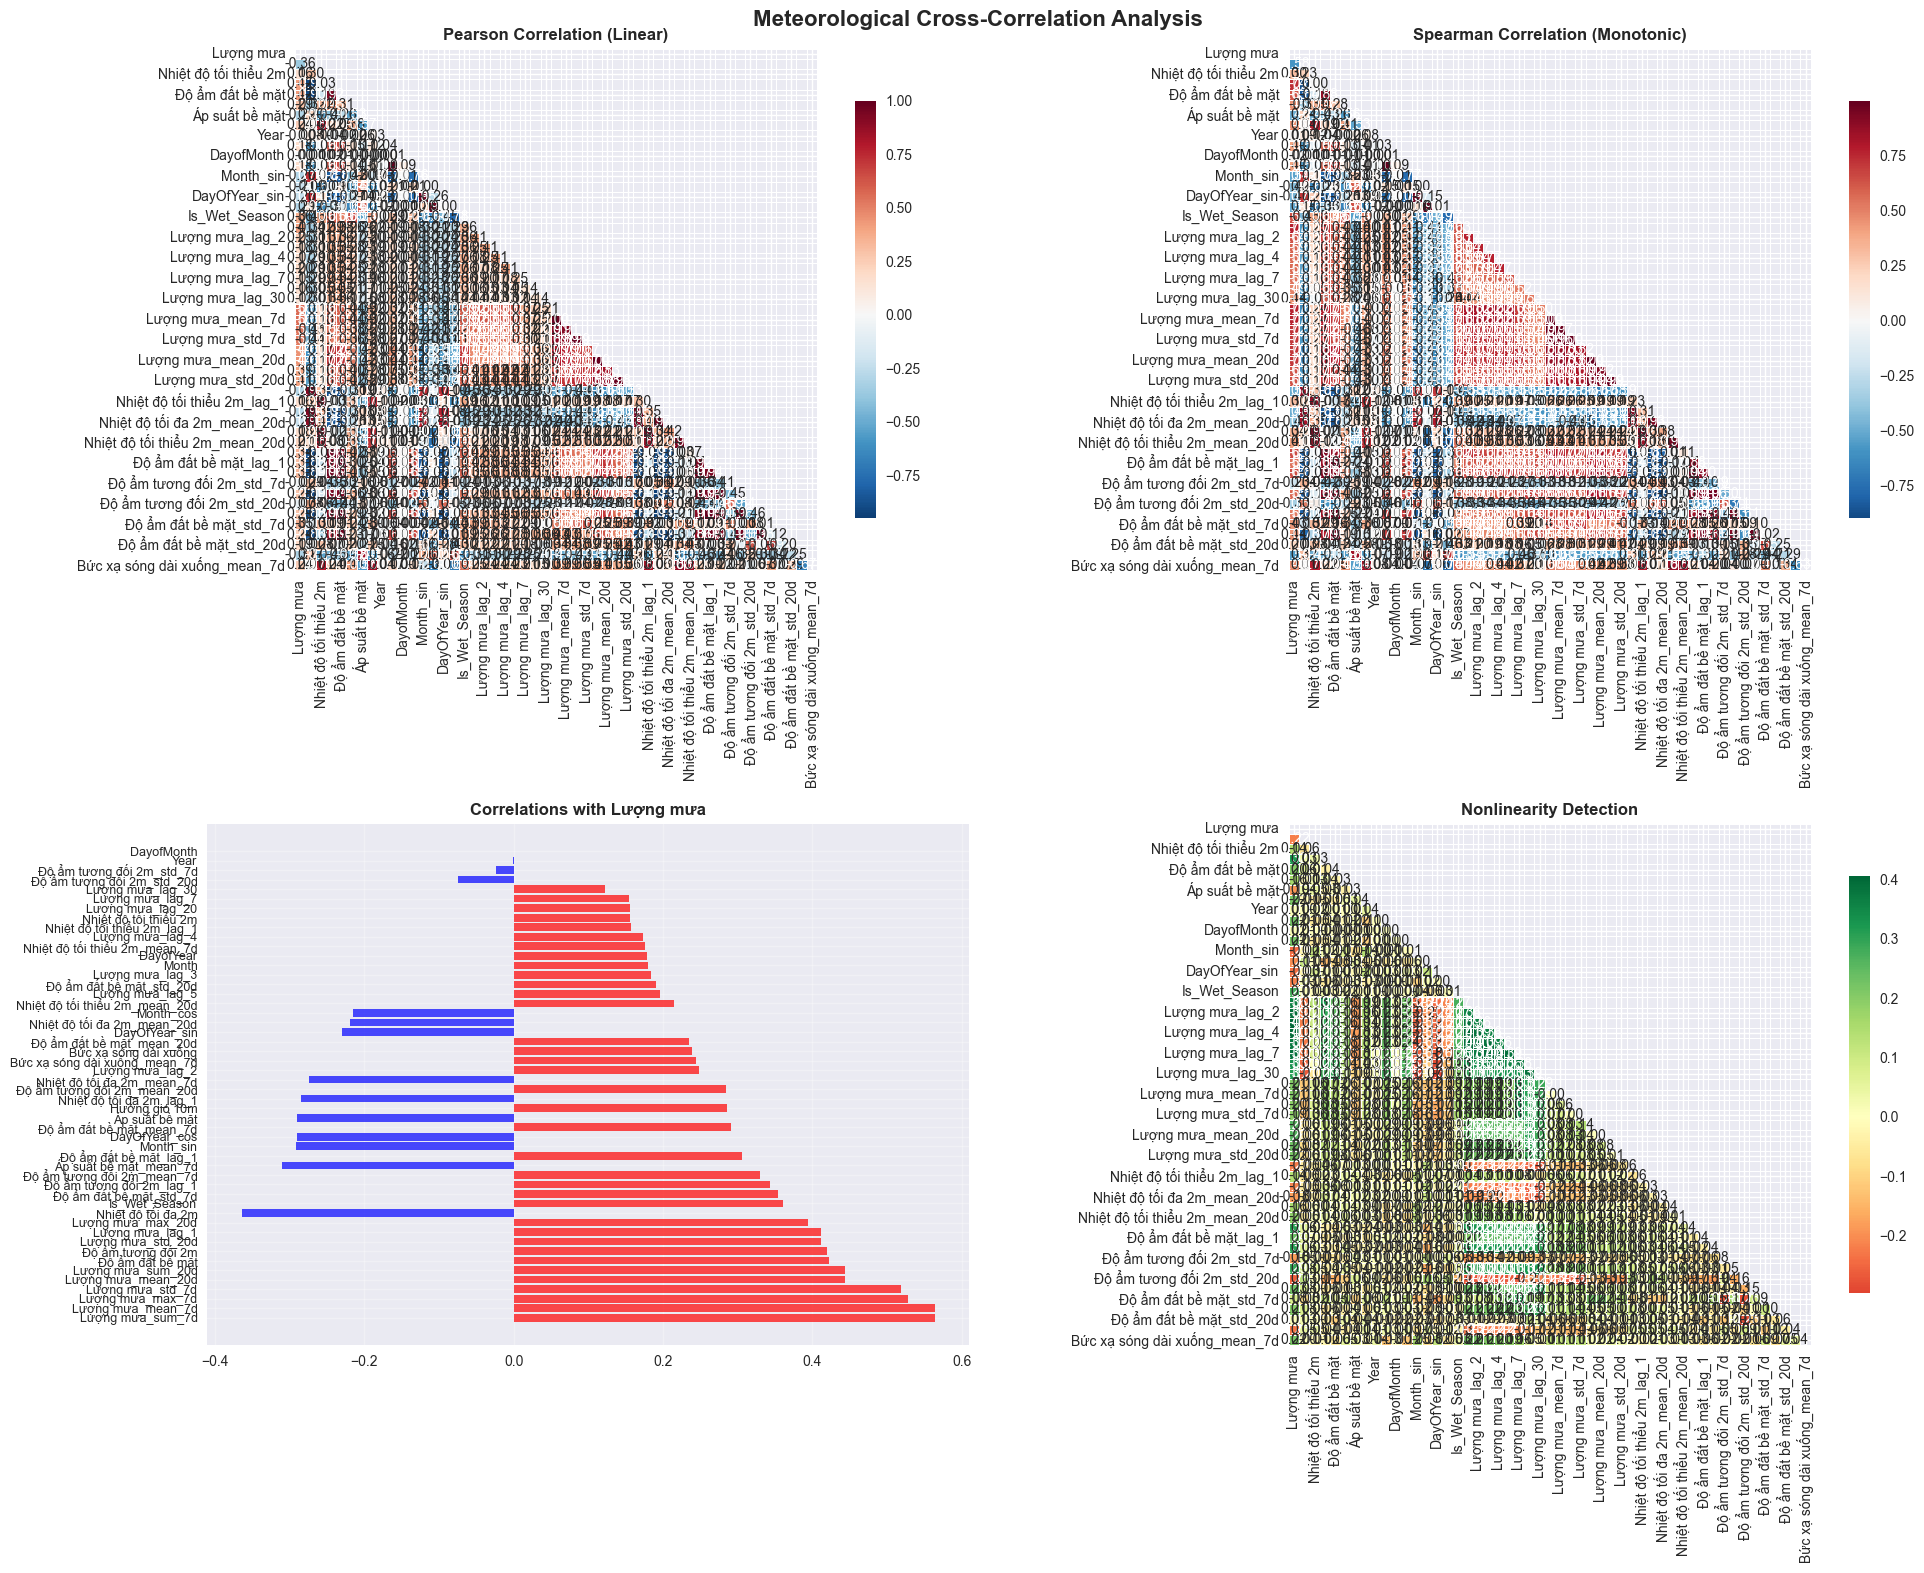

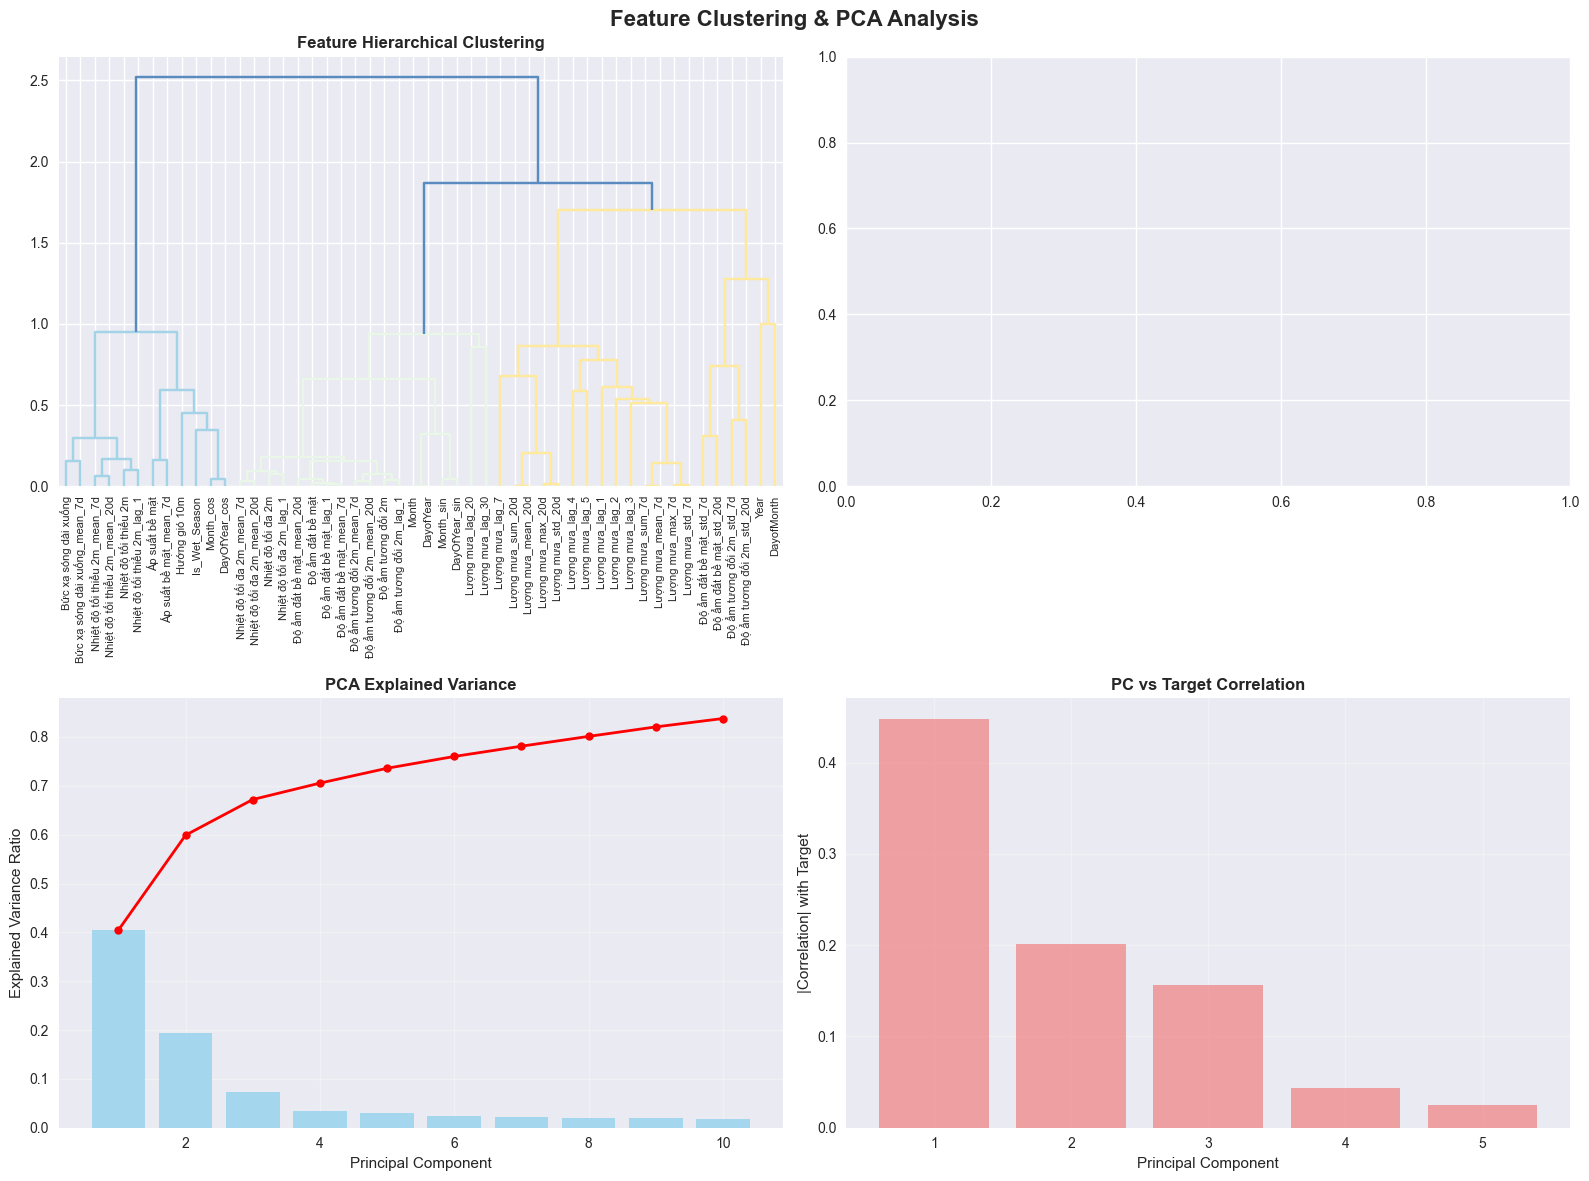

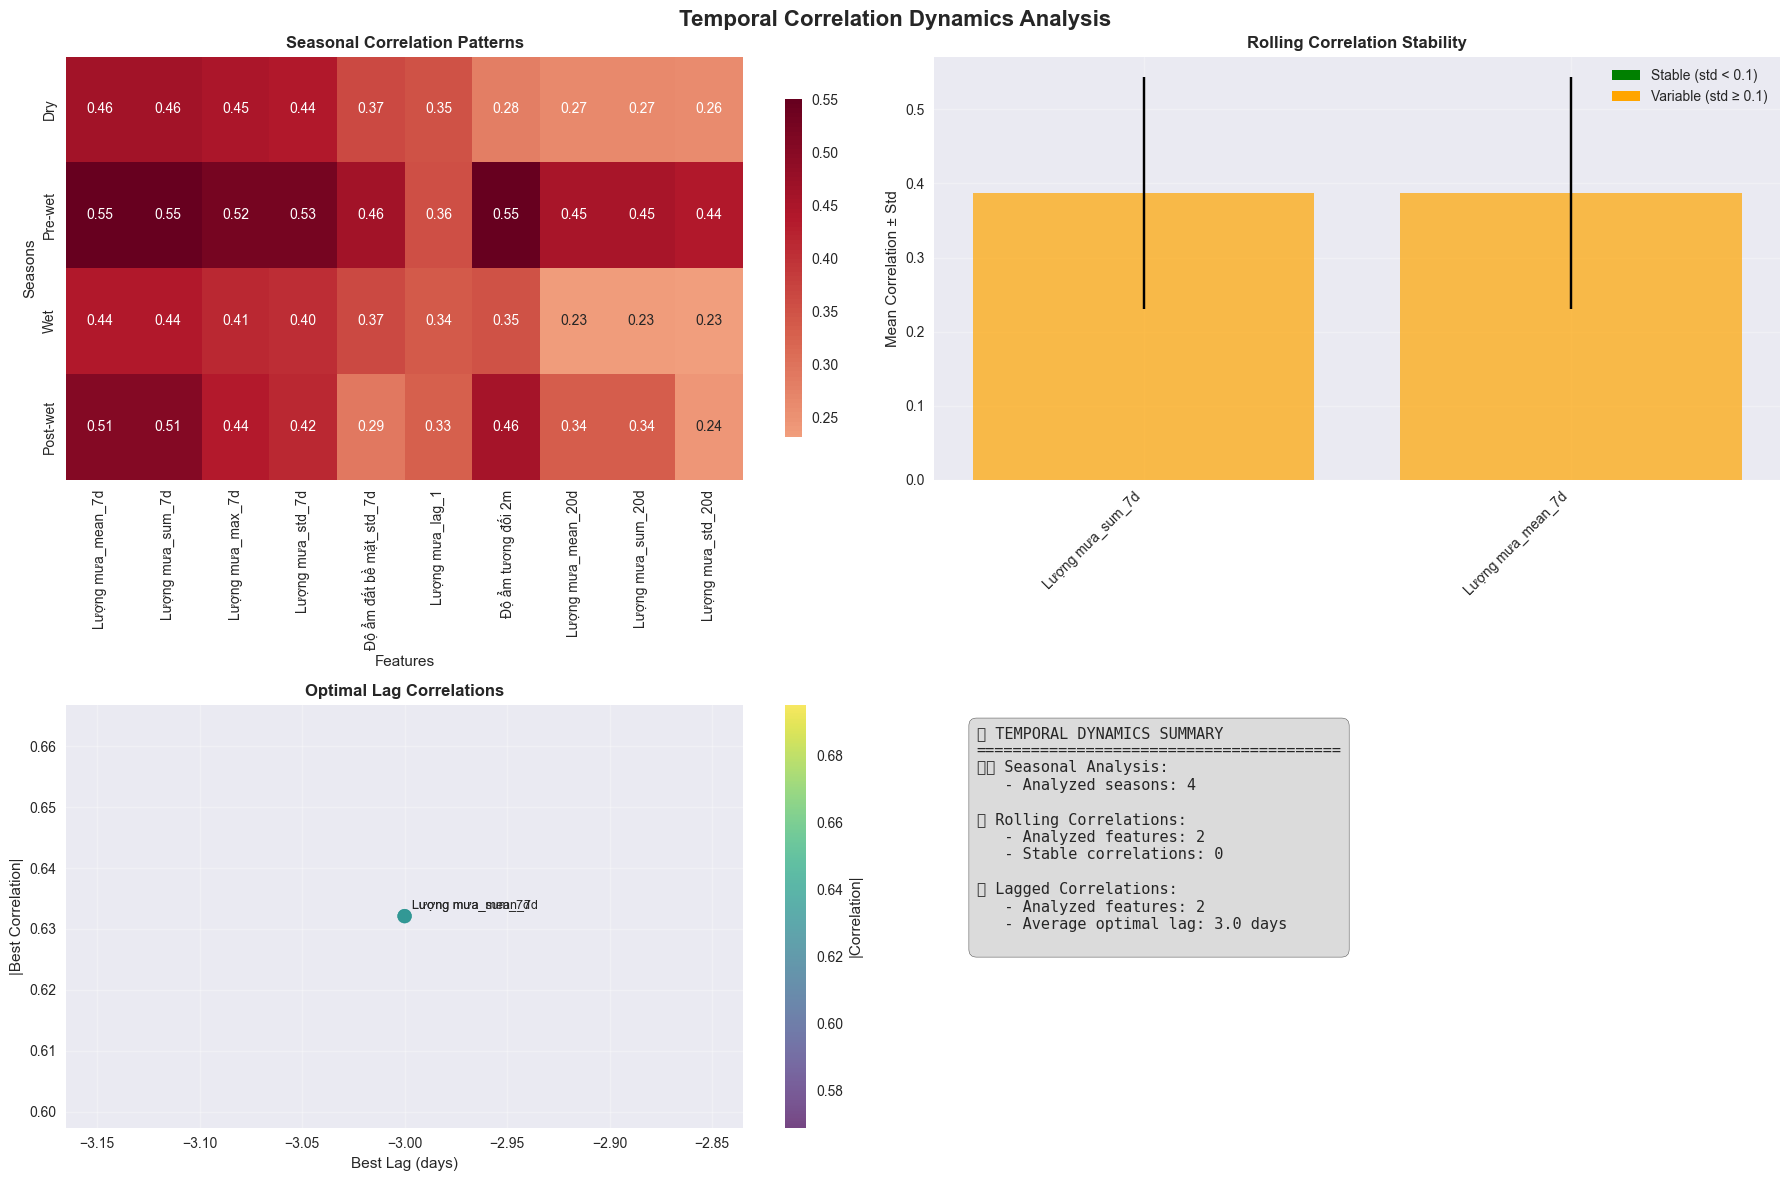

posx and posy should be finite values
posx and posy should be finite values


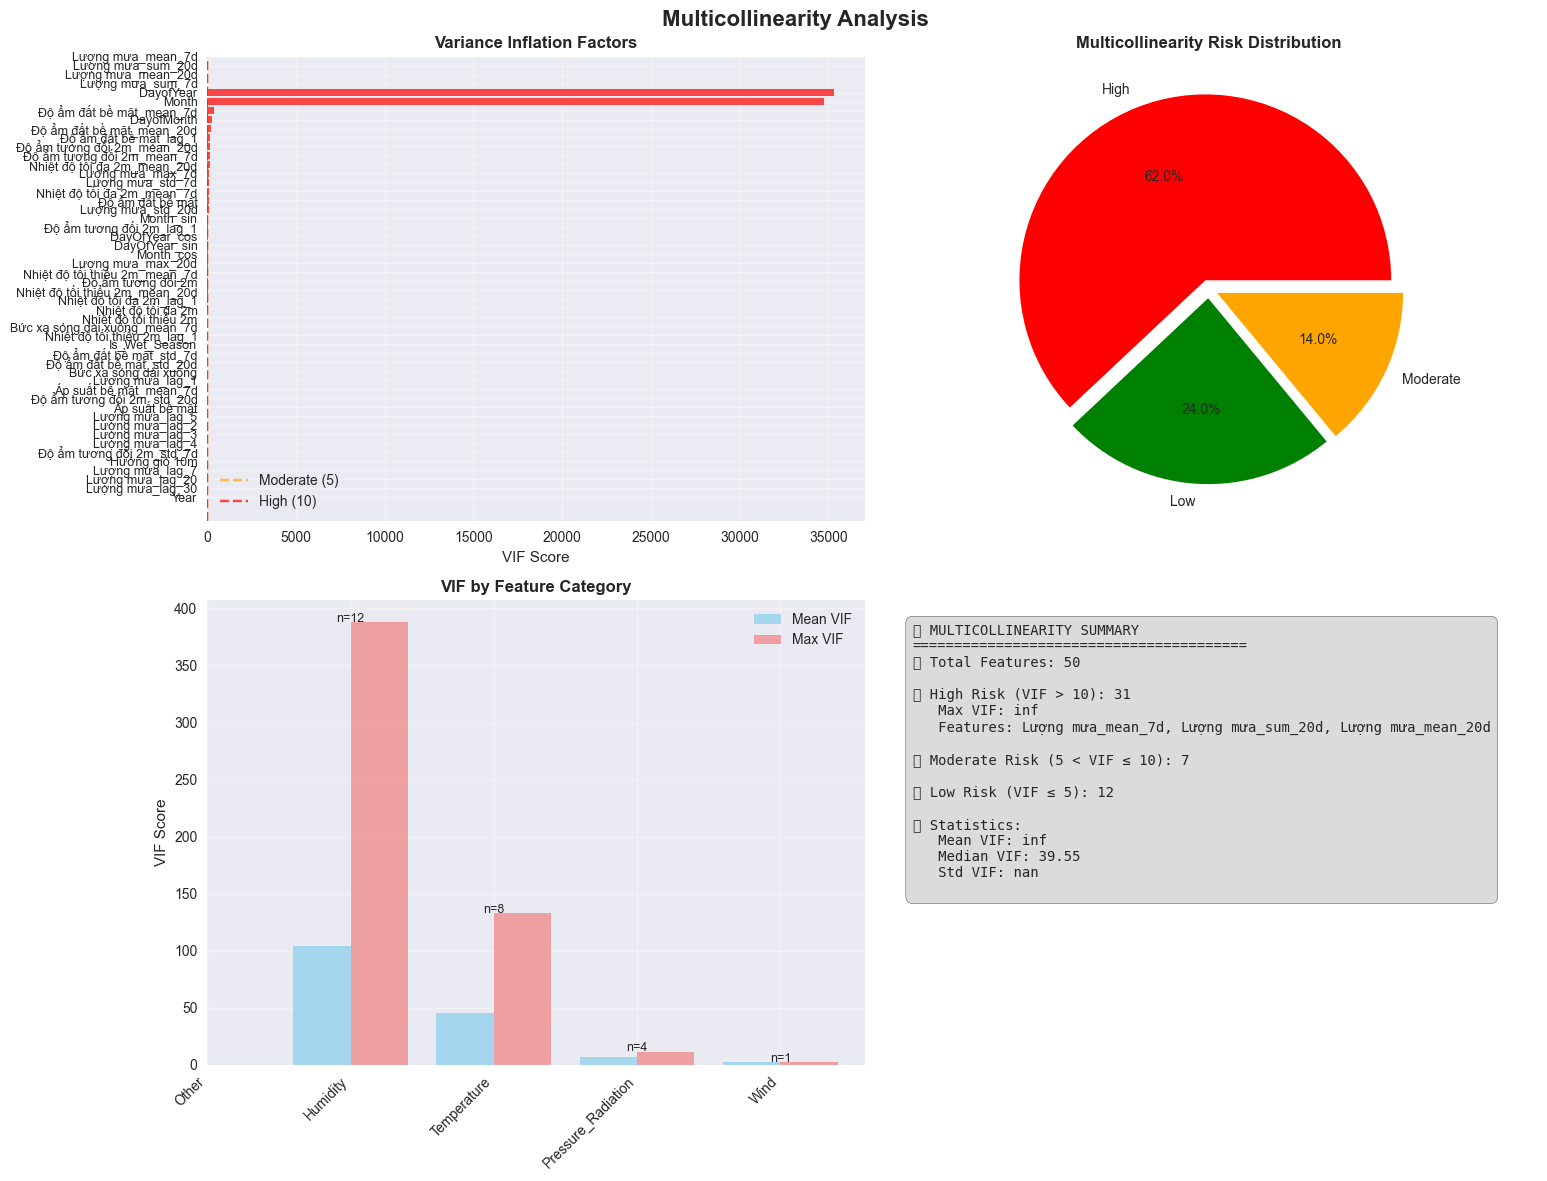

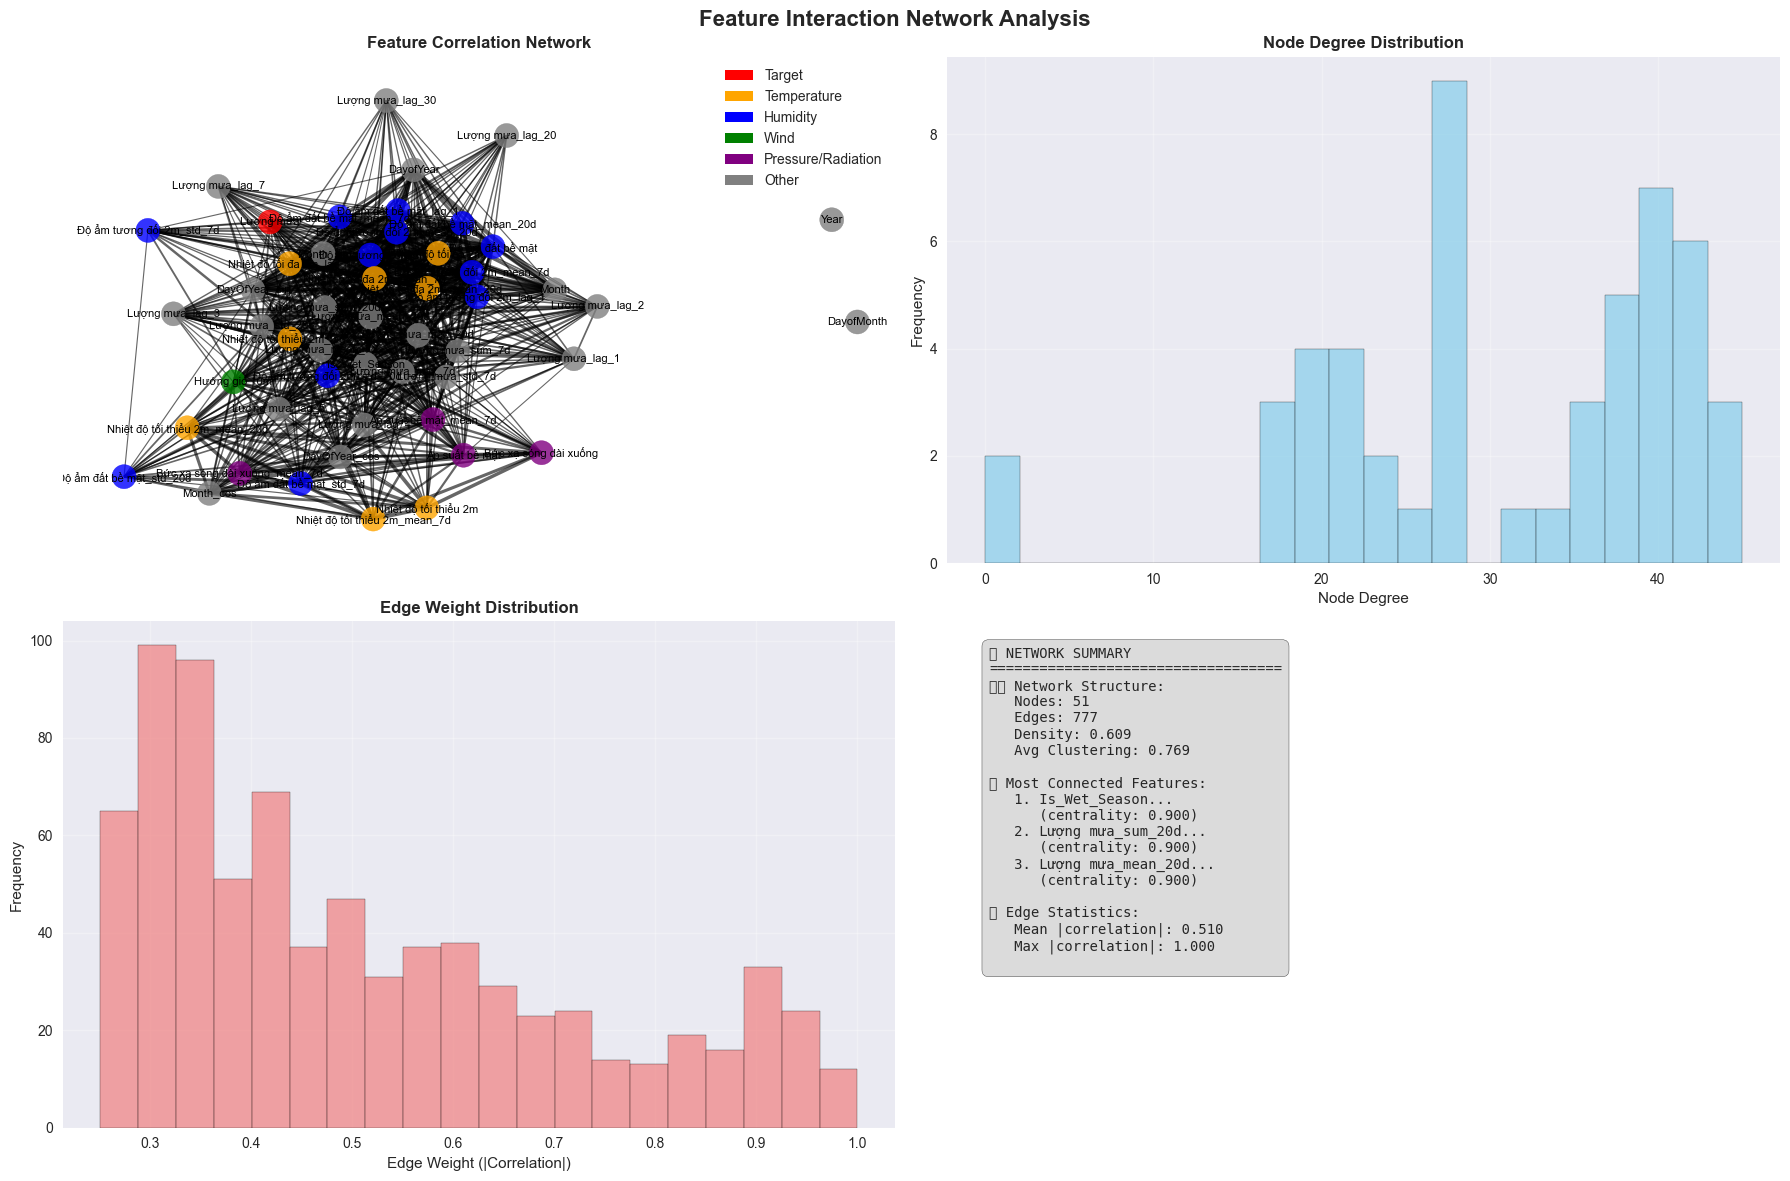


✅ CORRELATION ANALYSIS COMPLETED


In [42]:
from src.analysis.CorrelationAnalysis import analyze_correlations

# Chạy toàn bộ pipeline với visualization
results = analyze_correlations(df_final, target_col='Lượng mưa', date_col='Ngày', include_visualization=True)

# Modeling

## Tree-based model

In [ ]:
!pip install -q optuna

In [ ]:
# ==============================================================================
# LIGHTGBM TWO-STAGE MODEL WITH OPTUNA OPTIMIZATION (FIXED)
# ==============================================================================

import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("🚀 LIGHTGBM TWO-STAGE MODEL EXPERIMENTATION (FIXED)")
print("="*60)

print(f"📊 Data Setup:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Total samples: {len(X)}")
print(f"   Rain days: {y_clf.sum()} ({y_clf.mean()*100:.1f}%)")
print(f"   No rain days: {(1-y_clf).sum()} ({(1-y_clf.mean())*100:.1f}%)")

# Fixed Optuna optimization functions
def objective_classification_fixed(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1
    }

    auc_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_clf.iloc[train_idx], y_clf.iloc[test_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_data, num_boost_round=100)  # Removed verbose_eval

        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

def objective_regression_fixed(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1
    }

    mae_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

        rain_mask_train = y_clf.iloc[train_idx] == 1
        rain_mask_test = y_clf.iloc[test_idx] == 1

        if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
            X_train_rain = X_train[rain_mask_train]
            y_train_rain = y_train[rain_mask_train]
            X_test_rain = X_test[rain_mask_test]
            y_test_rain = y_test[rain_mask_test]

            train_data = lgb.Dataset(X_train_rain, label=y_train_rain)
            model = lgb.train(params, train_data, num_boost_round=100)  # Removed verbose_eval

            y_pred = model.predict(X_test_rain)
            mae = mean_absolute_error(y_test_rain, y_pred)
            mae_scores.append(mae)

    return np.mean(mae_scores) if mae_scores else float('inf')

# Optimize Classification Model
print("\n🔍 Optimizing Classification Model...")
study_clf_fixed = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_clf_fixed.optimize(objective_classification_fixed, n_trials=20)
best_params_clf_fixed = study_clf_fixed.best_params
print(f"   Best AUC: {study_clf_fixed.best_value:.4f}")

# Optimize Regression Model
print("\n🔍 Optimizing Regression Model...")
study_reg_fixed = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_reg_fixed.optimize(objective_regression_fixed, n_trials=20)
best_params_reg_fixed = study_reg_fixed.best_params
print(f"   Best MAE: {study_reg_fixed.best_value:.4f}")

# Final evaluation with best parameters
print("\n📊 Final Evaluation with Best Parameters:")
clf_results_fixed = {'AUC': []}
reg_results_fixed = {'MAE': [], 'RMSE': [], 'R2': []}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n🔄 Fold {fold + 1}/3")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_clf, y_test_clf = y_clf.iloc[train_idx], y_clf.iloc[test_idx]
    y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # Classification Model
    best_params_clf_fixed.update({'objective': 'binary', 'metric': 'auc', 'verbosity': -1})
    train_data_clf = lgb.Dataset(X_train, label=y_train_clf)
    clf_model = lgb.train(best_params_clf_fixed, train_data_clf, num_boost_round=100)

    clf_pred = clf_model.predict(X_test)
    auc = roc_auc_score(y_test_clf, clf_pred)
    clf_results_fixed['AUC'].append(auc)

    # Regression Model
    rain_mask_train = y_train_clf == 1
    rain_mask_test = y_test_clf == 1

    if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
        X_train_rain = X_train[rain_mask_train]
        y_train_rain = y_train_reg[rain_mask_train]
        X_test_rain = X_test[rain_mask_test]
        y_test_rain = y_test_reg[rain_mask_test]

        best_params_reg_fixed.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})
        train_data_reg = lgb.Dataset(X_train_rain, label=y_train_rain)
        reg_model = lgb.train(best_params_reg_fixed, train_data_reg, num_boost_round=100)

        reg_pred = reg_model.predict(X_test_rain)
        mae = mean_absolute_error(y_test_rain, reg_pred)
        rmse = np.sqrt(mean_squared_error(y_test_rain, reg_pred))
        r2 = r2_score(y_test_rain, reg_pred)

        reg_results_fixed['MAE'].append(mae)
        reg_results_fixed['RMSE'].append(rmse)
        reg_results_fixed['R2'].append(r2)

    print(f"   Classification AUC: {auc:.4f}")
    if rain_mask_test.sum() > 0:
        print(f"   Regression MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Summary Results
print("\n" + "="*60)
print("📋 LIGHTGBM FINAL RESULTS SUMMARY (FIXED)")
print("="*60)
print(f"Classification Model:")
print(f"   AUC: {np.mean(clf_results_fixed['AUC']):.4f} ± {np.std(clf_results_fixed['AUC']):.4f}")

if reg_results_fixed['MAE']:
    print(f"\nRegression Model (on rainy days only):")
    print(f"   MAE:  {np.mean(reg_results_fixed['MAE']):.4f} ± {np.std(reg_results_fixed['MAE']):.4f}")
    print(f"   RMSE: {np.mean(reg_results_fixed['RMSE']):.4f} ± {np.std(reg_results_fixed['RMSE']):.4f}")
    print(f"   R2:   {np.mean(reg_results_fixed['R2']):.4f} ± {np.std(reg_results_fixed['R2']):.4f}")

In [ ]:
# ==============================================================================
# XGBOOST TWO-STAGE MODEL WITH OPTUNA OPTIMIZATION
# ==============================================================================

import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("🚀 XGBOOST TWO-STAGE MODEL EXPERIMENTATION")
print("="*60)

# Use same data setup as LightGBM
print(f"📊 Data Setup:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Total samples: {len(X)}")
print(f"   Rain days: {y_clf.sum()} ({y_clf.mean()*100:.1f}%)")
print(f"   No rain days: {(1-y_clf).sum()} ({(1-y_clf.mean())*100:.1f}%)")

# Optuna optimization functions for XGBoost
def objective_classification_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
        'random_state': 42
    }

    auc_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_clf.iloc[train_idx], y_clf.iloc[test_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

def objective_regression_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
        'random_state': 42
    }

    mae_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

        # Only use rainy days for regression training
        rain_mask_train = y_clf.iloc[train_idx] == 1
        rain_mask_test = y_clf.iloc[test_idx] == 1

        if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
            X_train_rain = X_train[rain_mask_train]
            y_train_rain = y_train[rain_mask_train]
            X_test_rain = X_test[rain_mask_test]
            y_test_rain = y_test[rain_mask_test]

            model = xgb.XGBRegressor(**params)
            model.fit(X_train_rain, y_train_rain, verbose=False)

            y_pred = model.predict(X_test_rain)
            mae = mean_absolute_error(y_test_rain, y_pred)
            mae_scores.append(mae)

    return np.mean(mae_scores) if mae_scores else float('inf')

# Optimize Classification Model
print("\n🔍 Optimizing XGBoost Classification Model...")
study_clf_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_clf_xgb.optimize(objective_classification_xgb, n_trials=20)
best_params_clf_xgb = study_clf_xgb.best_params
print(f"   Best AUC: {study_clf_xgb.best_value:.4f}")

# Optimize Regression Model
print("\n🔍 Optimizing XGBoost Regression Model...")
study_reg_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_reg_xgb.optimize(objective_regression_xgb, n_trials=20)
best_params_reg_xgb = study_reg_xgb.best_params
print(f"   Best MAE: {study_reg_xgb.best_value:.4f}")

# Final evaluation with best parameters
print("\n📊 Final Evaluation with Best Parameters:")
clf_results_xgb = {'AUC': []}
reg_results_xgb = {'MAE': [], 'RMSE': [], 'R2': []}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n🔄 Fold {fold + 1}/3")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_clf, y_test_clf = y_clf.iloc[train_idx], y_clf.iloc[test_idx]
    y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # Classification Model
    best_params_clf_xgb.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'random_state': 42
    })
    clf_model_xgb = xgb.XGBClassifier(**best_params_clf_xgb)
    clf_model_xgb.fit(X_train, y_train_clf, verbose=False)

    # Classification predictions
    clf_pred_xgb = clf_model_xgb.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test_clf, clf_pred_xgb)
    clf_results_xgb['AUC'].append(auc)

    # Regression Model (only on rainy days)
    rain_mask_train = y_train_clf == 1
    rain_mask_test = y_test_clf == 1

    if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
        X_train_rain = X_train[rain_mask_train]
        y_train_rain = y_train_reg[rain_mask_train]
        X_test_rain = X_test[rain_mask_test]
        y_test_rain = y_test_reg[rain_mask_test]

        best_params_reg_xgb.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'verbosity': 0,
            'random_state': 42
        })
        reg_model_xgb = xgb.XGBRegressor(**best_params_reg_xgb)
        reg_model_xgb.fit(X_train_rain, y_train_rain, verbose=False)

        # Regression predictions
        reg_pred_xgb = reg_model_xgb.predict(X_test_rain)
        mae = mean_absolute_error(y_test_rain, reg_pred_xgb)
        rmse = np.sqrt(mean_squared_error(y_test_rain, reg_pred_xgb))
        r2 = r2_score(y_test_rain, reg_pred_xgb)

        reg_results_xgb['MAE'].append(mae)
        reg_results_xgb['RMSE'].append(rmse)
        reg_results_xgb['R2'].append(r2)

    print(f"   Classification AUC: {auc:.4f}")
    if rain_mask_test.sum() > 0:
        print(f"   Regression MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Summary Results
print("\n" + "="*60)
print("📋 XGBOOST FINAL RESULTS SUMMARY")
print("="*60)
print(f"Classification Model:")
print(f"   AUC: {np.mean(clf_results_xgb['AUC']):.4f} ± {np.std(clf_results_xgb['AUC']):.4f}")

if reg_results_xgb['MAE']:
    print(f"\nRegression Model (on rainy days only):")
    print(f"   MAE:  {np.mean(reg_results_xgb['MAE']):.4f} ± {np.std(reg_results_xgb['MAE']):.4f}")
    print(f"   RMSE: {np.mean(reg_results_xgb['RMSE']):.4f} ± {np.std(reg_results_xgb['RMSE']):.4f}")
    print(f"   R2:   {np.mean(reg_results_xgb['R2']):.4f} ± {np.std(reg_results_xgb['R2']):.4f}")

## Times series model

In [ ]:
# ==============================================================================
# STATIONARITY TESTING FOR EXOGENOUS FEATURES (ADF & KPSS)
# ==============================================================================

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# Define exogenous features (original selected features)
exogenous_features = [
    'Nhiệt độ tối đa 2m',      # T2M_MAX
    'Nhiệt độ tối thiểu 2m',    # T2M_MIN
    'Độ ẩm tương đối 2m',       # RH2M
    'Độ ẩm đất bề mặt',         # GWETTOP
    'Hướng gió 10m',            # WD10M
    'Áp suất bề mặt',           # PS
    'Bức xạ sóng dài xuống'     # ALLSKY_SFC_LW_DWN
]

print("📊 STATIONARITY TESTING FOR EXOGENOUS FEATURES")
print("="*60)

stationarity_results = {}

for feature in exogenous_features:
    print(f"\n🔍 Testing: {feature}")

    # ADF Test
    adf_result = adfuller(df_selected[feature].dropna())
    adf_stationary = adf_result[1] < 0.05

    # KPSS Test
    kpss_result = kpss(df_selected[feature].dropna())
    kpss_stationary = kpss_result[1] > 0.05

    # Overall conclusion
    if adf_stationary and kpss_stationary:
        conclusion = "STATIONARY"
    elif not adf_stationary and not kpss_stationary:
        conclusion = "NON-STATIONARY"
    else:
        conclusion = "INCONCLUSIVE"

    # Store results
    stationarity_results[feature] = {
        'ADF_pvalue': adf_result[1],
        'ADF_stationary': adf_stationary,
        'KPSS_pvalue': kpss_result[1],
        'KPSS_stationary': kpss_stationary,
        'Conclusion': conclusion
    }

    print(f"   ADF p-value: {adf_result[1]:.6f} ({'Stationary' if adf_stationary else 'Non-stationary'})")
    print(f"   KPSS p-value: {kpss_result[1]:.6f} ({'Stationary' if kpss_stationary else 'Non-stationary'})")
    print(f"   ➤ Conclusion: {conclusion}")

# Summary
print("\n" + "="*60)
print("📋 STATIONARITY SUMMARY:")
stationary_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'STATIONARY')
non_stationary_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'NON-STATIONARY')
inconclusive_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'INCONCLUSIVE')

print(f"   Stationary features: {stationary_count}")
print(f"   Non-stationary features: {non_stationary_count}")
print(f"   Inconclusive features: {inconclusive_count}")

In [ ]:
# Chỉ cần import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Prepare data
print("🚀 TIME SERIES MODELS EXPERIMENTATION")
print("="*60)

# Use original features for exogenous variables (7 features)
exog_features = [
    'Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m',
    'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống'
]

# Target variable
target = df_selected['Lượng mưa']
exog_data_original = df_selected[exog_features]

# ==============================================================================
# >>>>>>>>>>>> START OF FIX 1: MAKE EXOGENOUS VARIABLES STATIONARY <<<<<<<<<<<<
# ==============================================================================
exog_data_stationary = pd.DataFrame(index=exog_data_original.index)

print("🩺 Checking and transforming exogenous variables for stationarity...")
for col in exog_data_original.columns:
    # ADF test to check for unit root
    adf_pvalue = adfuller(exog_data_original[col].dropna())[1]
    if adf_pvalue >= 0.05:
        # If not stationary, apply first difference
        print(f"   - Column '{col}' is non-stationary (p={adf_pvalue:.3f}). Applying differencing.")
        exog_data_stationary[col] = exog_data_original[col].diff()
    else:
        # If stationary, use as is
        print(f"   - Column '{col}' is stationary (p={adf_pvalue:.3f}).")
        exog_data_stationary[col] = exog_data_original[col]

# Drop NaNs created by differencing
exog_data_stationary = exog_data_stationary.dropna()
# Align target variable with the new stationary exogenous data
target = target.loc[exog_data_stationary.index]
print("   ✅ All exogenous variables are now stationary.")
# ==============================================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>> END OF FIX 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# ==============================================================================


# Time Series Cross-Validation setup
tscv = TimeSeriesSplit(n_splits=5)
print(f"\n📊 Data Setup:")
print(f"   Total samples after alignment: {len(target)}")
print(f"   CV splits: 5")

# Results storage
results = {
    'ARIMA': {'MAE': [], 'RMSE': [], 'R2': []},
    'SARIMA': {'MAE': [], 'RMSE': [], 'R2': []},
    'ARIMAX': {'MAE': [], 'RMSE': [], 'R2': []},
    'SARIMAX': {'MAE': [], 'RMSE': [], 'R2': []}
}

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(tscv.split(target)):
    print(f"\n🔄 Fold {fold + 1}/5")

    # Split data
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    # Use the stationary exogenous data
    X_train, X_test = exog_data_stationary.iloc[train_idx], exog_data_stationary.iloc[test_idx]

    # Define model orders
    order = (3, 0, 3)
    seasonal_order = (1, 1, 1, 7)

    # ==============================================================================
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>> START OF FIX 2 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    # ==============================================================================
    # Use SARIMAX for all models for consistency

    # 1. ARIMA
    try:
        model = SARIMAX(y_train, order=order).fit(disp=False)
        pred = model.forecast(steps=len(y_test))
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['ARIMA']['MAE'].append(mae); results['ARIMA']['RMSE'].append(rmse); results['ARIMA']['R2'].append(r2)
        print(f"   ARIMA: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   ARIMA: Failed - {e}")

    # 2. SARIMA
    try:
        model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
        pred = model.forecast(steps=len(y_test))
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['SARIMA']['MAE'].append(mae); results['SARIMA']['RMSE'].append(rmse); results['SARIMA']['R2'].append(r2)
        print(f"   SARIMA: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   SARIMA: Failed - {e}")

    # 3. ARIMAX
    try:
        model = SARIMAX(y_train, exog=X_train, order=order).fit(disp=False)
        pred = model.forecast(steps=len(y_test), exog=X_test)
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['ARIMAX']['MAE'].append(mae); results['ARIMAX']['RMSE'].append(rmse); results['ARIMAX']['R2'].append(r2)
        print(f"   ARIMAX: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   ARIMAX: Failed - {e}")

    # 4. SARIMAX
    try:
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
        pred = model.forecast(steps=len(y_test), exog=X_test)
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['SARIMAX']['MAE'].append(mae); results['SARIMAX']['RMSE'].append(rmse); results['SARIMAX']['R2'].append(r2)
        print(f"   SARIMAX: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   SARIMAX: Failed - {e}")